# Homework 3: Financial Ratio Quantile Strategies
##### Name: Anand Nakhate
##### Student ID: 12446907
##### Date: 30 January 2025


### Abstract
In this study, we develop and test quantile‐based long-short equity strategies derived from three fundamental factors—Debt‐to‐Market‐Cap, Return on Investment, and Price‐to‐Earnings—to create a multi‐factor “zscore_sum_of_factors” signal. The goal is to rank U.S. stocks daily, long the top deciles of “best fundamentals,” and short the bottom deciles of “worst fundamentals.” We examine variations in:
- Quantile thresholds (5%, 10%, 20%),
- Weighting schemes (equal vs. market‐cap),
- Signal modes (normal vs. reversed), and
- Short financing rates (from 1% up to 5%) that gets paid to us*.

Key Findings:
- Best Performer: A 20% quantile multi‐factor approach—summing cross‐sectional z‐scores of debt, ROI, and P/E—weighted by market cap—yielded the highest final capital and stable risk metrics.
- Normal vs. Reversed: “Normal” signals (long top fraction) outperformed consistently; “reversed” signals exhibited negative returns, higher drawdowns, and subpar Sharpe ratios.
- Short Rate Sensitivity: Increasing the short borrowing rate from 1% to 5% nearly halved the strategy’s net alpha, underscoring how short financing can erode gains.
- Fama‐French Analysis: The final best strategy loaded heavily on the RMW (profitability) factor, with a negative tilt toward HML (value). Its alpha was not significantly different from zero once controlling for known factors—but it still served as a robust “quality plus growth” style.
- Drawdowns: While maximum drawdown remained under 15% (substantially lower than broad equity drawdowns), correlation with SPY could spike in bull phases. This underscores partial diversification benefits but reveals that factor strategies are not always crisis‐proof.

Relevance:
- This approach suits a low‐beta, “absolute return” product if short fees are well‐managed.
- Strategies punishing high debt thrive when interest rates rise; robust ROI picks up “quality” in crises like COVID and a hawkish Fed environment.
- Market‐cap weighting can scale more easily than equal weighting, making it appealing for institutional managers seeking large allocations.

These results highlight both the promise and limitations of a quantile‐based, multi‐factor “quality” L/S approach, emphasizing the importance of no‐lookahead bias, robust data assembly, and factoring in real‐world costs (short borrowing) to avoid overestimating alpha.

In [1]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import warnings
from functools import reduce
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
warnings.filterwarnings("ignore")

# Data Aquisition and Cleaning

The study is constructed using the Zacks Fundamentals B dataset, encompassing six interrelated tables: 
- Financials (FC),
- Financial Ratios (FR),
- Market Trends (MT),
-  Market Values (MKTV),
-  Shareholder Information (SHRC), and
-  Historical Data Metrics (HDM).

The data spans from January 2017 to June 2024. The investment universe comprises around 950 companies, selected based on filtering criteria to ensure data robustness and investment viability. Specifically, we include
- firms with consistently available end-of-day adjusted closing prices,
- a market value exceeding $1 million throughout the study period, and
- a debt-to-market capitalization ratio exceeding 0.1 at least once,
-  eliminate companies within the automotive, financial, and insurance sectors

The analysis focuses on three key financial ratios:

- Debt to Market Capitalization: Calculated as total debt divided by market capitalization, this ratio serves as an indicator of financial leverage and risk exposure.
- Return on Investment (ROI): Derived from operating income relative to investment, where investment is defined as the sum of market capitalization and long-term debt. This ratio reflects the efficiency with which a company utilizes its capital to generate profits.
- Price to Earnings (P/E): Computed using free cash flow per diluted earnings per share, this ratio gauges market valuation relative to earnings, providing insights into growth expectations and market sentiment.

Given that these financial metrics are reported quarterly, we employ data compilation to interpolate daily values. This involves forward-filling equity prices to align with reporting dates and inferring unreported variables using available financial data points. The methodology addresses potential data sparsity and ensures that each ratio is calculable on a daily basis, thereby allowing the construction of trading signals. By defining and processing the dataset, this report ensures that the analysis of quantile-based strategies is grounded in reliable and comprehensive financial information.

## Data Download

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [3]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False)
display(prices)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/QUOTEMEDIA/PRICES_20250131.zip size 1669770198 exists already, no need to download


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,JTKWY,2022-03-11,6.1700,7.3200,5.7900,6.7200,9440097.0,0.0,1.0,6.1700,7.3200,5.7900,6.7200,9440097.0
1,JTKWY,2022-03-10,6.1600,6.1750,5.9350,6.0700,2261623.0,0.0,1.0,6.1600,6.1750,5.9350,6.0700,2261623.0
2,FG_1,2020-06-01,8.1000,8.3900,8.1000,8.3900,3086317.0,0.0,1.0,8.1000,8.3900,8.1000,8.3900,3086317.0
3,YTENQ,2024-09-30,0.9514,1.0500,0.9514,1.0500,842.0,0.0,1.0,0.9514,1.0500,0.9514,1.0500,842.0
4,FLWS,2022-03-09,14.5700,14.9588,14.4100,14.4500,662492.0,0.0,1.0,14.5700,14.9588,14.4100,14.4500,662492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51289038,PRCS,2024-12-16,24.9600,24.9600,24.8900,24.9306,6474.0,0.0,1.0,24.9600,24.9600,24.8900,24.9306,6474.0
51289039,PRVS,2024-12-16,24.9116,24.9184,24.7446,24.7446,6889.0,0.0,1.0,24.9116,24.9184,24.7446,24.7446,6889.0
51289040,SCDV,2024-12-16,24.8600,24.8800,24.7800,24.8100,2212.0,0.0,1.0,24.8600,24.8800,24.7800,24.8100,2212.0
51289041,ATLN,2024-12-16,5.5111,5.7550,4.9500,5.4000,8514.0,0.0,1.0,5.5111,5.7550,4.9500,5.4000,8514.0


In [4]:
zfc = fetch_quandl_table('ZACKS/FC', avoid_download=False)
display(zfc)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/FC_20250131.zip size 199649400 exists already, no need to download


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,stock_based_compsn_qd,cash_flow_oper_activity_qd,net_change_prop_plant_equip_qd,comm_stock_div_paid_qd,pref_stock_div_paid_qd,tot_comm_pref_stock_div_qd,wavg_shares_out,wavg_shares_out_diluted,eps_basic_net,eps_diluted_net
0,YSTI,V.NTS,NaN,NANOTECH SECRTY,NaN,CND,2015-03-31,Q,NaN,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,48.751,48.751,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686837,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2021-09-30,Q,NaN,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686838,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2021-12-31,Q,NaN,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686839,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2022-03-31,Q,NaN,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686840,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2022-06-30,Q,NaN,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
zfr = fetch_quandl_table('ZACKS/FR', avoid_download=False)
display(zfr)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/FR_20250131.zip size 40994594 exists already, no need to download


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_end_date,per_type,per_code,per_fisc_year,...,invty_turn,rcv_turn,day_sale_rcv,ret_equity,ret_tang_equity,ret_asset,ret_invst,free_cash_flow_per_share,book_val_per_share,oper_cash_flow_per_share
0,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2006-12-31,A,NaN,2006,...,NaN,NaN,NaN,2.4085,1.3277,0.7184,2.3844,NaN,NaN,NaN
1,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2007-12-31,A,NaN,2007,...,NaN,NaN,NaN,-0.2536,-0.1624,-0.0851,-0.2411,NaN,NaN,NaN
2,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2008-12-31,A,NaN,2008,...,NaN,NaN,NaN,-0.1566,-0.0905,-0.0507,-0.1497,NaN,NaN,NaN
3,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2009-12-31,A,NaN,2009,...,NaN,NaN,NaN,-0.2429,-0.1426,-0.0778,-0.2328,NaN,NaN,NaN
4,CPG,3262Q,NaN,CMS ENERGY -G,NaN,USD,2010-12-31,A,NaN,2010,...,NaN,NaN,NaN,-0.0653,-0.0375,-0.0209,-0.0627,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686837,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2019-06-30,Q,NaN,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686838,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2021-12-31,Q,NaN,2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686839,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2022-03-31,Q,NaN,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686840,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,USD,2022-06-30,Q,NaN,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
zmt = fetch_quandl_table('ZACKS/MT', avoid_download=False)
display(zmt)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/MT_20250131.zip size 1042405 exists already, no need to download


,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,ticker_type,active_ticker_flag,comp_url,sic_4_code,...,per_end_month_nbr,mr_split_date,mr_split_factor,comp_cik,country_code,country_name,comp_type,optionable_flag,sp500_member_flag,asset_type
0,Z86Z,0425B,NaN,PCA INTL,NaN,NaN,NaN,N,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FFFC,1186Q,NaN,FRANKLIN FIRST,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WSTF,1197Q,NaN,WESTERN FINL CP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HBCI,1209Q,NaN,HARMONIA,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TONE,1352Q,NaN,ONE BCP,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39971,YTVU,ZYTV,NaN,YORKSHIRE-TYNE,NaN,NaN,NaN,N,NaN,NaN,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39972,ZYXI,ZYXI,Zynex,Zynex Inc.,NASDAQ,USD,S,Y,http://www.zynex.com,3845.0,...,12,2022-01-05,1.1,846475.0,US,UNITED STATES,1.0,Y,N,COM
39973,ZZ,ZZ,NaN,SEALY CORP,NaN,NaN,NaN,N,NaN,NaN,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39974,BHN#,ZZLL,NaN,ZZLL INFO TEC,NaN,NaN,NaN,N,NaN,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
zmktv = fetch_quandl_table('ZACKS/MKTV', avoid_download=False)
display(zmktv)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/MKTV_20250131.zip size 7399003 exists already, no need to download


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,mkt_val,ep_val
0,A,A2,AGILENT TECH,10,Q,2024-09-30,Y,42662.41,43020.41
1,A,A2,AGILENT TECH,10,Q,2024-06-30,Y,37820.96,38285.96
2,A,A2,AGILENT TECH,10,Q,2024-03-31,Y,42642.48,43449.48
3,A,A2,AGILENT TECH,10,Q,2023-12-31,Y,40741.31,41886.31
4,A,A2,AGILENT TECH,10,Q,2023-09-30,Y,32717.11,34122.11
...,...,...,...,...,...,...,...,...,...
1107086,ZZ,ZZ,SEALY CORP,11,Q,2007-03-31,N,1598.88,2378.88
1107087,ZZ,ZZ,SEALY CORP,11,Q,2006-12-31,N,1342.00,2110.61
1107088,ZZ,ZZ,SEALY CORP,11,Q,2006-09-30,N,1188.43,1962.01
1107089,ZZ,ZZ,SEALY CORP,11,Q,2006-06-30,N,1201.16,1973.05


In [8]:
zshrs = fetch_quandl_table('ZACKS/SHRS', avoid_download=False)
display(zshrs)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/SHRS_20250131.zip size 5590929 exists already, no need to download


,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,shares_out,avg_d_shares
0,A,A2,AGILENT TECH,10,Q,2024-07-31,Y,287.33,291.00
1,A,A2,AGILENT TECH,10,Q,2024-04-30,Y,291.76,293.00
2,A,A2,AGILENT TECH,10,Q,2024-01-31,Y,293.05,294.00
3,A,A2,AGILENT TECH,10,Q,2023-10-31,Y,292.59,293.00
4,A,A2,AGILENT TECH,10,Q,2023-07-31,Y,292.59,295.00
...,...,...,...,...,...,...,...,...,...
1107162,ZZ,ZZ,SEALY CORP,11,Q,2007-02-28,N,91.47,96.58
1107163,ZZ,ZZ,SEALY CORP,11,Q,2006-11-30,N,90.98,97.73
1107164,ZZ,ZZ,SEALY CORP,11,Q,2006-08-31,N,91.00,96.66
1107165,ZZ,ZZ,SEALY CORP,11,Q,2006-05-31,N,90.52,88.40


In [9]:
zhdm = fetch_quandl_table('ZACKS/HDM', avoid_download=False)
display(zhdm)

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/ZACKS/HDM_20250131.zip size 1240418 exists already, no need to download


,action_type,m_ticker,status,per_end_month_nbr,comp_name,ticker,change_txt,ex_date,proc_date
0,4,ALS2,1,12,I-SECTOR CORP,ISR,INX INC,NaN,2006-01-03
1,6,BDE,1,12,BRILLIANT DIGIT,BDLN,0.1000,2006-01-03,2006-01-03
2,4,PHE1,1,12,PETROL HELI-NVT,PHELK,PHI INC-NVT,NaN,2006-01-03
3,4,WW,1,6,WATSON WYATT CO,WW,WATSON WYATT WW,NaN,2006-01-03
4,5,IAD,1,12,RYERSON INC,RT,RYI,NaN,2006-01-03
...,...,...,...,...,...,...,...,...,...
71141,1,TWNP,1,12,TWIN HOSPITLTY,TWNP,NaN,NaN,2025-01-30
71142,1,BCLO,1,12,IS-BBB B CLO AC,BCLO,NaN,NaN,2025-01-30
71143,1,BBNX,1,12,BETA BIONICS,BBNX,NaN,NaN,2025-01-30
71144,4,YGIT,1,12,GITENNES EXPLOR,V.GIT,REV EXPLORATION,NaN,2025-01-30


## Fundamental Data Table Creation

In [10]:
prices['date'] = pd.to_datetime(prices['date'])
zfc['per_end_date'] = pd.to_datetime(zfc['per_end_date'])
zfr['per_end_date'] = pd.to_datetime(zfr['per_end_date'])
zmktv['per_end_date'] = pd.to_datetime(zmktv['per_end_date'])
zshrs['per_end_date'] = pd.to_datetime(zshrs['per_end_date'])

In [11]:
start_date = '2017-01-01'
end_date = '2024-06-30'

prices = prices[(prices['date'] >= start_date) & (prices['date'] <= end_date)]
zfc = zfc[(zfc['per_end_date'] >= start_date) & (zfc['per_end_date'] <= end_date) & (zfc['per_type'] == 'Q')]
zfr = zfr[(zfr['per_end_date'] >= start_date) & (zfr['per_end_date'] <= end_date) & (zfr['per_type'] == 'Q')]
zmktv = zmktv[(zmktv['per_end_date'] >= start_date) & (zmktv['per_end_date'] <= end_date)  & (zmktv['per_type'] == 'Q')]
zshrs = zshrs[(zshrs['per_end_date'] >= start_date) & (zshrs['per_end_date'] <= end_date)  & (zshrs['per_type'] == 'Q')]

In [12]:
# the market value (as reported in MKTV3) never dips below $1MM, over the entire period Jan 2017 through Jun 2024
market_value_filtered = zmktv.copy()
market_value_filtered['mkt_val'] = market_value_filtered['mkt_val'].astype(float)
tickers_market_value_filtered = set(list(map(str, market_value_filtered.groupby('ticker').filter(lambda x: (x['mkt_val'] >= 1).all())['ticker'].unique())))
print(f"Tickers with market value >= $1MM throughout: {len(tickers_market_value_filtered)}")

Tickers with market value >= $1MM throughout: 3584


In [13]:
# debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2017 through Jun 2024 (preferably more than fleetingly)
debt_market_cap_filtered = zfr.copy()
debt_market_cap_filtered['tot_debt_tot_equity'] = debt_market_cap_filtered['tot_debt_tot_equity'].astype(float)
tickers_debt_market_cap_filtered = set(list(map(str, debt_market_cap_filtered.groupby('ticker').filter(lambda x: (x['tot_debt_tot_equity'] > 0.1).any())['ticker'].unique())))
print(f"Tickers with debt to market cap value >= 0.1 at least once: {len(tickers_debt_market_cap_filtered)}")

Tickers with debt to market cap value >= 0.1 at least once: 7703


In [14]:
# Filter - not in the automotive, financial, or insurance sector, over the entire period Jan 2017 through Jun 2024
excluded_sectors_codes = [13, 5]
industry_filtered = zfc.copy()
industry_filtered = industry_filtered[~industry_filtered['zacks_sector_code'].isin(excluded_sectors_codes)]
tickers_excluded_sectors = set(list(map(str, industry_filtered['ticker'].unique())))
print(f"Tickers not in automative, financial or insurance sectors: {len(tickers_excluded_sectors)}")

Tickers not in automative, financial or insurance sectors: 9055


In [15]:
universe = tickers_market_value_filtered & tickers_debt_market_cap_filtered  & tickers_excluded_sectors
len(universe)

2238

In [16]:
zfc_columns = ['ticker', 'per_end_date', 'filing_date', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps']
zfr_columns = ['ticker', 'per_end_date', 'tot_debt_tot_equity', 'ret_invst']
zmktv_columns = ['ticker', 'per_end_date', 'mkt_val']
zshrs_columns = ['ticker', 'per_end_date', 'shares_out']

In [17]:
dfs = [zfc[zfc_columns], zfr[zfr_columns], zmktv[zmktv_columns], zshrs[zshrs_columns]]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['ticker', 'per_end_date'], how='inner'), dfs)
merged_df = merged_df[merged_df['ticker'].isin(universe)]
merged_df = merged_df.sort_values(by=['ticker', 'per_end_date']).drop_duplicates()
merged_df

,ticker,per_end_date,filing_date,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,tot_debt_tot_equity,ret_invst,mkt_val,shares_out
3,AA,2017-03-31,2017-05-10,-3.0,1431.0,1.21,1.23,0.1778,3.2103,6337.48,184.23
4,AA,2017-06-30,2017-08-03,-7.0,1418.0,0.40,0.41,0.1753,1.4350,6015.44,184.24
5,AA,2017-09-30,2017-10-27,-52.0,1384.0,0.60,0.61,0.1726,1.7786,8625.77,185.02
7,AA,2017-12-31,2018-02-26,-39.0,1388.0,-0.72,-1.06,0.2065,-0.0855,9976.78,185.20
8,AA,2018-03-31,2018-05-09,57.0,1445.0,1.04,0.81,0.1942,3.7938,8370.47,186.18
...,...,...,...,...,...,...,...,...,...,...,...
163720,ZWS,2023-06-30,2023-07-24,-3.1,549.1,0.20,0.20,0.3496,1.5390,4650.56,172.95
163721,ZWS,2023-09-30,2023-10-31,-4.7,547.9,0.24,0.24,0.3439,1.6300,4842.15,172.81
163722,ZWS,2023-12-31,2024-02-06,-64.9,494.4,0.07,0.08,0.3090,0.6437,5082.36,172.81
163723,ZWS,2024-03-31,2024-04-23,-0.2,494.5,0.19,0.20,0.3070,1.6126,5780.16,172.70


In [18]:
merged_df['net_lterm_debt'] = pd.to_numeric(merged_df['net_lterm_debt'], errors='coerce')
merged_df['tot_lterm_debt'] = pd.to_numeric(merged_df['tot_lterm_debt'], errors='coerce')
merged_df['mkt_val'] = pd.to_numeric(merged_df['mkt_val'], errors='coerce')

def calculate_debt(row):
    if pd.notna(row['net_lterm_debt']):
        return row['net_lterm_debt']
    elif pd.notna(row['tot_lterm_debt']):
        return row['tot_lterm_debt']
    else:
        return 0

def calculate_eps(row):
    eps = np.nan
    if pd.notna(row['eps_diluted_net']):
        eps = row['eps_diluted_net']
    elif pd.notna(row['basic_net_eps']):
        eps = row['basic_net_eps']
    
    if eps < 0:
        eps = 0.001    
    return eps


merged_df['debt'] = merged_df.apply(calculate_debt, axis=1)
merged_df['eps'] = merged_df.apply(calculate_eps, axis=1)
merged_df.head()

,ticker,per_end_date,filing_date,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps
3,AA,2017-03-31,2017-05-10,-3.0,1431.0,1.21,1.23,0.1778,3.2103,6337.48,184.23,-3.0,1.210
4,AA,2017-06-30,2017-08-03,-7.0,1418.0,0.40,0.41,0.1753,1.4350,6015.44,184.24,-7.0,0.400
5,AA,2017-09-30,2017-10-27,-52.0,1384.0,0.60,0.61,0.1726,1.7786,8625.77,185.02,-52.0,0.600
7,AA,2017-12-31,2018-02-26,-39.0,1388.0,-0.72,-1.06,0.2065,-0.0855,9976.78,185.20,-39.0,0.001
8,AA,2018-03-31,2018-05-09,57.0,1445.0,1.04,0.81,0.1942,3.7938,8370.47,186.18,57.0,1.040


In [19]:
merged_df.drop(['net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps'], axis=1, inplace=True)
merged_df = merged_df.dropna()
merged_df = merged_df[merged_df['eps']!=0]
merged_df

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps
3,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.210
4,AA,2017-06-30,2017-08-03,0.1753,1.4350,6015.44,184.24,-7.0,0.400
5,AA,2017-09-30,2017-10-27,0.1726,1.7786,8625.77,185.02,-52.0,0.600
7,AA,2017-12-31,2018-02-26,0.2065,-0.0855,9976.78,185.20,-39.0,0.001
8,AA,2018-03-31,2018-05-09,0.1942,3.7938,8370.47,186.18,57.0,1.040
...,...,...,...,...,...,...,...,...,...
163720,ZWS,2023-06-30,2023-07-24,0.3496,1.5390,4650.56,172.95,-3.1,0.200
163721,ZWS,2023-09-30,2023-10-31,0.3439,1.6300,4842.15,172.81,-4.7,0.240
163722,ZWS,2023-12-31,2024-02-06,0.3090,0.6437,5082.36,172.81,-64.9,0.070
163723,ZWS,2024-03-31,2024-04-23,0.3070,1.6126,5780.16,172.70,-0.2,0.190


In [20]:
merged_df['filing_date'] = pd.to_datetime(merged_df['filing_date'])
merged_df['effective_date'] = merged_df['filing_date'] + pd.offsets.BusinessDay(n=1)
merged_df.sort_values(by=['ticker', 'per_end_date'], ascending=[True, True])
merged_df

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date
3,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.210,2017-05-11
4,AA,2017-06-30,2017-08-03,0.1753,1.4350,6015.44,184.24,-7.0,0.400,2017-08-04
5,AA,2017-09-30,2017-10-27,0.1726,1.7786,8625.77,185.02,-52.0,0.600,2017-10-30
7,AA,2017-12-31,2018-02-26,0.2065,-0.0855,9976.78,185.20,-39.0,0.001,2018-02-27
8,AA,2018-03-31,2018-05-09,0.1942,3.7938,8370.47,186.18,57.0,1.040,2018-05-10
...,...,...,...,...,...,...,...,...,...,...
163720,ZWS,2023-06-30,2023-07-24,0.3496,1.5390,4650.56,172.95,-3.1,0.200,2023-07-25
163721,ZWS,2023-09-30,2023-10-31,0.3439,1.6300,4842.15,172.81,-4.7,0.240,2023-11-01
163722,ZWS,2023-12-31,2024-02-06,0.3090,0.6437,5082.36,172.81,-64.9,0.070,2024-02-07
163723,ZWS,2024-03-31,2024-04-23,0.3070,1.6126,5780.16,172.70,-0.2,0.190,2024-04-24


In [21]:
ticker_counts = merged_df.groupby("ticker").size()
tickers_with_30_entries = ticker_counts[ticker_counts == 30].index.tolist()
merged_df = merged_df[merged_df['ticker'].isin(tickers_with_30_entries)]
merged_df.sort_values(by=['ticker', 'per_end_date'], ascending=[True, True])
merged_df

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date
3,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.210,2017-05-11
4,AA,2017-06-30,2017-08-03,0.1753,1.4350,6015.44,184.24,-7.0,0.400,2017-08-04
5,AA,2017-09-30,2017-10-27,0.1726,1.7786,8625.77,185.02,-52.0,0.600,2017-10-30
7,AA,2017-12-31,2018-02-26,0.2065,-0.0855,9976.78,185.20,-39.0,0.001,2018-02-27
8,AA,2018-03-31,2018-05-09,0.1942,3.7938,8370.47,186.18,57.0,1.040,2018-05-10
...,...,...,...,...,...,...,...,...,...,...
163586,ZTS,2023-06-30,2023-08-08,1.4190,5.9950,79580.33,462.11,-1350.0,1.450,2023-08-09
163587,ZTS,2023-09-30,2023-11-02,1.2917,5.1264,79876.60,459.11,-1350.0,1.290,2023-11-03
163588,ZTS,2023-12-31,2024-02-13,1.3158,4.5262,90615.27,459.11,-1350.0,1.140,2024-02-14
163589,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.310,2024-05-03


In [22]:
prices_df = prices[['ticker', 'date', 'adj_close']].rename(columns={'adj_close': 'price'}).dropna()
prices_df = prices_df.sort_values(by=['ticker', 'date'], ascending=[True, True])
prices_df

,ticker,date,price
25562163,A,2017-01-03,43.833212
25562120,A,2017-01-04,44.408352
25562070,A,2017-01-05,43.880355
25561585,A,2017-01-06,45.247491
25561584,A,2017-01-09,45.388919
...,...,...,...
49571158,ZZZ,2024-06-25,24.936900
9473833,ZZZ,2024-06-26,24.760000
34161557,ZZZ,2024-06-27,24.212700
51010144,ZZZ,2024-06-28,23.986900


In [23]:
merged_df['per_end_date'] = pd.to_datetime(merged_df['per_end_date'])
prices_df['date'] = pd.to_datetime(prices_df['date'])
merged_df.sort_values(by=['ticker', 'per_end_date'], ascending=[True, True]).reset_index(drop=True)
prices_df.sort_values(by=['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

df1 = merged_df.copy()
df2 = prices_df.copy()
df1['per_end_date'] = pd.to_datetime(df1['per_end_date'])
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.drop_duplicates(subset=['ticker', 'date'], keep='last')
merged = pd.merge(df1, df2, on='ticker', how='left')
merged = merged[merged['date'] <= merged['per_end_date']]
merged = merged.sort_values(by=['ticker', 'per_end_date', 'date'])
idx = merged.groupby(['ticker', 'per_end_date'])['date'].idxmax()
report_prices = merged.loc[idx, ['ticker', 'per_end_date', 'price']].rename(columns={'price': 'report_price'})
df1 = pd.merge(df1, report_prices, on=['ticker', 'per_end_date'], how='left')
df1['report_price'] = df1.groupby('ticker')['report_price'].ffill()
df1[['ticker', 'per_end_date', 'report_price']]

,ticker,per_end_date,report_price
0,AA,2017-03-31,33.295146
1,AA,2017-06-30,31.601352
2,AA,2017-09-30,45.122666
3,AA,2017-12-31,52.139811
4,AA,2018-03-31,43.515981
...,...,...,...
29125,ZTS,2023-06-30,169.735717
29126,ZTS,2023-09-30,171.855002
29127,ZTS,2023-12-31,195.424983
29128,ZTS,2024-03-31,167.922430


In [24]:
df1.dropna(inplace=True)
ticker_counts = df1.groupby("ticker").size()
tickers_with_30_entries = ticker_counts[ticker_counts == 30].index.tolist()
df1 = df1[df1['ticker'].isin(tickers_with_30_entries)].reset_index(drop=True)
print("Unique Fundamental data ticker universe count: ", len(df1['ticker'].unique()))
fundamental_data = df1.copy()
fundamental_data

Unique Fundamental data ticker universe count:  941


,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price
0,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.210,2017-05-11,33.295146
1,AA,2017-06-30,2017-08-03,0.1753,1.4350,6015.44,184.24,-7.0,0.400,2017-08-04,31.601352
2,AA,2017-09-30,2017-10-27,0.1726,1.7786,8625.77,185.02,-52.0,0.600,2017-10-30,45.122666
3,AA,2017-12-31,2018-02-26,0.2065,-0.0855,9976.78,185.20,-39.0,0.001,2018-02-27,52.139811
4,AA,2018-03-31,2018-05-09,0.1942,3.7938,8370.47,186.18,57.0,1.040,2018-05-10,43.515981
...,...,...,...,...,...,...,...,...,...,...,...
28225,ZTS,2023-06-30,2023-08-08,1.4190,5.9950,79580.33,462.11,-1350.0,1.450,2023-08-09,169.735717
28226,ZTS,2023-09-30,2023-11-02,1.2917,5.1264,79876.60,459.11,-1350.0,1.290,2023-11-03,171.855002
28227,ZTS,2023-12-31,2024-02-13,1.3158,4.5262,90615.27,459.11,-1350.0,1.140,2024-02-14,195.424983
28228,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.310,2024-05-03,167.922430


In [25]:
duplicates = fundamental_data[fundamental_data.duplicated(subset=['ticker', 'effective_date'], keep=False)]
print("Number of duplicate rows in fundamental_df based on 'ticker' and 'effective_date':", duplicates.shape[0])
fundamental_data = fundamental_data[~fundamental_data['ticker'].isin(list(duplicates['ticker'].unique()))]
print("Unique Fundamental data ticker universe count: ", len(fundamental_data['ticker'].unique()))
fundamental_data

Number of duplicate rows in fundamental_df based on 'ticker' and 'effective_date': 33
Unique Fundamental data ticker universe count:  928


,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price
0,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.210,2017-05-11,33.295146
1,AA,2017-06-30,2017-08-03,0.1753,1.4350,6015.44,184.24,-7.0,0.400,2017-08-04,31.601352
2,AA,2017-09-30,2017-10-27,0.1726,1.7786,8625.77,185.02,-52.0,0.600,2017-10-30,45.122666
3,AA,2017-12-31,2018-02-26,0.2065,-0.0855,9976.78,185.20,-39.0,0.001,2018-02-27,52.139811
4,AA,2018-03-31,2018-05-09,0.1942,3.7938,8370.47,186.18,57.0,1.040,2018-05-10,43.515981
...,...,...,...,...,...,...,...,...,...,...,...
28225,ZTS,2023-06-30,2023-08-08,1.4190,5.9950,79580.33,462.11,-1350.0,1.450,2023-08-09,169.735717
28226,ZTS,2023-09-30,2023-11-02,1.2917,5.1264,79876.60,459.11,-1350.0,1.290,2023-11-03,171.855002
28227,ZTS,2023-12-31,2024-02-13,1.3158,4.5262,90615.27,459.11,-1350.0,1.140,2024-02-14,195.424983
28228,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.310,2024-05-03,167.922430


In [26]:
## Daily Master Table Creation

In [27]:
prices_df = prices_df[prices_df['ticker'].isin(tickers_with_30_entries)].reset_index(drop=True)
prices_df

,ticker,date,price
0,AA,2017-01-03,27.904042
1,AA,2017-01-04,29.288114
2,AA,2017-01-05,29.665588
3,AA,2017-01-06,29.694624
4,AA,2017-01-09,28.533166
...,...,...,...
1771798,ZTS,2024-06-24,171.013575
1771799,ZTS,2024-06-25,167.172139
1771800,ZTS,2024-06-26,170.078095
1771801,ZTS,2024-06-27,175.611356


In [28]:
fundamental_data['per_end_date'] = pd.to_datetime(fundamental_data['per_end_date'])
fundamental_data['filing_date'] = pd.to_datetime(fundamental_data['filing_date'])
fundamental_data['effective_date'] = pd.to_datetime(fundamental_data['effective_date'])
fundamental_data = fundamental_data.drop_duplicates(subset=['ticker', 'effective_date'], keep='last')
prices_df['date'] = pd.to_datetime(prices_df['date'])

df = pd.merge(fundamental_data, prices_df, how="right", left_on=["ticker", "effective_date"], right_on=["ticker", "date"])
df = df.sort_values(by=['ticker', 'date'], ascending=[True, True])
df

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price,date,price
0,AA,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2017-01-03,27.904042
1,AA,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2017-01-04,29.288114
2,AA,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2017-01-05,29.665588
3,AA,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2017-01-06,29.694624
4,AA,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2017-01-09,28.533166
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771798,ZTS,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2024-06-24,171.013575
1771799,ZTS,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2024-06-25,167.172139
1771800,ZTS,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2024-06-26,170.078095
1771801,ZTS,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2024-06-27,175.611356


In [29]:
df_sorted = df.sort_values(['ticker', 'date']).reset_index(drop=True)
columns_to_ffill = [col for col in df_sorted.columns if col not in ['ticker', 'date', 'price']]
df_sorted[columns_to_ffill] = df_sorted.groupby('ticker')[columns_to_ffill].ffill()
df_filled = df_sorted.dropna(subset=['report_price'])
df_filled = df_filled.reset_index(drop=True)
df = df_filled
df

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price,date,price
0,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.21,2017-05-11,33.295146,2017-05-11,30.159208
1,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.21,2017-05-11,33.295146,2017-05-12,30.768973
2,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.21,2017-05-11,33.295146,2017-05-15,31.001265
3,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.21,2017-05-11,33.295146,2017-05-16,31.127090
4,AA,2017-03-31,2017-05-10,0.1778,3.2103,6337.48,184.23,-3.0,1.21,2017-05-11,33.295146,2017-05-17,30.614112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667704,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.31,2024-05-03,167.922430,2024-06-24,171.013575
1667705,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.31,2024-05-03,167.922430,2024-06-25,167.172139
1667706,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.31,2024-05-03,167.922430,2024-06-26,170.078095
1667707,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.70,456.30,6562.0,1.31,2024-05-03,167.922430,2024-06-27,175.611356


In [30]:
### Financial Ratio Calculation

In [31]:
# Price to earnings
df["market_cap"] = (df["mkt_val"] / df["report_price"]) * df["price"]
df["price_to_earnings"] = df["price"]/df["eps"]
df.tail()

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price,date,price,market_cap,price_to_earnings
1667704,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-24,171.013575,78630.989405,130.544714
1667705,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-25,167.172139,76864.720671,127.612319
1667706,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-26,170.078095,78200.861786,129.830607
1667707,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-27,175.611356,80745.020893,134.054470
1667708,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-28,172.526265,79326.514916,131.699439


In [32]:
# return on investment
df["investment"] = df["debt"] + df["market_cap"]
df["return"] = df["ret_invst"] * (df["debt"] + df["mkt_val"])
df["return_on_investment"] = df["return"] / df["investment"]
df.tail()

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price,date,price,market_cap,price_to_earnings,investment,return,return_on_investment
1667704,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-24,171.013575,78630.989405,130.544714,85192.989405,432060.91992,5.071555
1667705,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-25,167.172139,76864.720671,127.612319,83426.720671,432060.91992,5.178927
1667706,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-26,170.078095,78200.861786,129.830607,84762.861786,432060.91992,5.097290
1667707,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-27,175.611356,80745.020893,134.054470,87307.020893,432060.91992,4.948753
1667708,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-28,172.526265,79326.514916,131.699439,85888.514916,432060.91992,5.030485


In [33]:
# Debt to Market Cap (debt to total equity)
df["debt_to_market_cap"] = df["tot_debt_tot_equity"]* df["report_price"]/ df["price"]

In [34]:
df = df.dropna()
df.tail()

,ticker,per_end_date,filing_date,tot_debt_tot_equity,ret_invst,mkt_val,shares_out,debt,eps,effective_date,report_price,date,price,market_cap,price_to_earnings,investment,return,return_on_investment,debt_to_market_cap
1667704,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-24,171.013575,78630.989405,130.544714,85192.989405,432060.91992,5.071555,1.280037
1667705,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-25,167.172139,76864.720671,127.612319,83426.720671,432060.91992,5.178927,1.309451
1667706,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-26,170.078095,78200.861786,129.830607,84762.861786,432060.91992,5.097290,1.287077
1667707,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-27,175.611356,80745.020893,134.054470,87307.020893,432060.91992,4.948753,1.246523
1667708,ZTS,2024-03-31,2024-05-02,1.3036,5.1576,77209.7,456.3,6562.0,1.31,2024-05-03,167.92243,2024-06-28,172.526265,79326.514916,131.699439,85888.514916,432060.91992,5.030485,1.268814


In [35]:
df = df[['date', 'ticker', 'price', 'market_cap', 'debt_to_market_cap', 'return_on_investment', 'price_to_earnings']].reset_index(drop=True)
df.tail()

,date,ticker,price,market_cap,debt_to_market_cap,return_on_investment,price_to_earnings
1667704,2024-06-24,ZTS,171.013575,78630.989405,1.280037,5.071555,130.544714
1667705,2024-06-25,ZTS,167.172139,76864.720671,1.309451,5.178927,127.612319
1667706,2024-06-26,ZTS,170.078095,78200.861786,1.287077,5.097290,129.830607
1667707,2024-06-27,ZTS,175.611356,80745.020893,1.246523,4.948753,134.054470
1667708,2024-06-28,ZTS,172.526265,79326.514916,1.268814,5.030485,131.699439


### Sanity Check

In [37]:
# Sanity Check:
data = {
    "date": [
        "2022-10-26", "2022-10-27", "2022-12-30", "2023-01-03", "2023-02-07",
        "2023-02-08", "2023-03-31", "2023-04-03", "2023-04-27", "2023-04-28",
        "2023-06-30", "2023-07-03", "2023-07-26", "2023-07-27", "2023-09-29",
        "2023-10-02", "2023-10-25", "2023-10-26", "2023-12-29", "2024-01-02",
        "2024-02-13", "2024-02-14", "2024-03-28", "2024-04-01", "2024-04-25",
        "2024-04-26", "2024-06-28"
    ],
    "debt_to_market_cap": [
        1.891277, 2.029799, 2.040269, 2.038320, 2.115096,
        2.270112, 2.089139, 2.080215, 2.109044, 2.218444,
        2.115070, 2.139997, 2.223811, 2.346040, 2.512278,
        2.532714, 2.334197, 2.073791, 1.877599, 1.872267,
        1.685688, 2.116358, 1.970425, 1.972646, 1.974594,
        2.307417, 2.272374
    ],
    "return_on_investment": [
        2.634588, 3.106361, 3.122265, 3.119305, 3.235886,
        2.423785, 2.234389, 2.225033, 2.255253, 2.393665,
        2.282654, 2.309427, 2.399427, 2.975598, 3.185491,
        3.211284, 2.960639, 2.805577, 2.541350, 2.534167,
        2.282649, 1.852862, 1.726437, 1.728362, 1.730051,
        3.104420, 3.092638
    ],
    "price_to_earnings": [
        109.896458, 99.569072, 99.058098, 99.152812, 95.553684,
        121.236072, 131.738209, 132.303367, 130.494863, 124.782115,
        130.880818, 129.356315, 124.480925, 106.538755, 99.489084,
        98.686332, 107.079336, 98.440449, 108.726575, 109.036182,
        121.104771, 161.536257, 173.499906, 173.304551, 173.133615,
        119.223466, 121.062038
    ]
}
df_wm = pd.DataFrame(data)
df_wm["date"] = pd.to_datetime(df_wm["date"])
df_wm

,date,debt_to_market_cap,return_on_investment,price_to_earnings
0,2022-10-26,1.891277,2.634588,109.896458
1,2022-10-27,2.029799,3.106361,99.569072
2,2022-12-30,2.040269,3.122265,99.058098
3,2023-01-03,2.038320,3.119305,99.152812
4,2023-02-07,2.115096,3.235886,95.553684
5,2023-02-08,2.270112,2.423785,121.236072
6,2023-03-31,2.089139,2.234389,131.738209
7,2023-04-03,2.080215,2.225033,132.303367
8,2023-04-27,2.109044,2.255253,130.494863
9,2023-04-28,2.218444,2.393665,124.782115


In [38]:
df[(df['ticker'] == 'WM') & (df['date'].isin(list(df_wm['date'])))]

,date,ticker,price,market_cap,debt_to_market_cap,return_on_investment,price_to_earnings
1622318,2022-10-26,WM,154.954006,66368.919334,1.891277,2.634588,109.896458
1622319,2022-10-27,WM,153.336371,64978.528694,2.029799,3.106361,99.569072
1622363,2022-12-30,WM,152.549470,64645.068251,2.040269,3.122265,99.058098
1622364,2023-01-03,WM,152.695330,64706.878299,2.038320,3.119305,99.152812
1622388,2023-02-07,WM,147.152673,62358.096497,2.115096,3.235886,95.553684
1622389,2023-02-08,WM,146.695647,61924.577760,2.270112,2.423785,121.236072
1622425,2023-03-31,WM,159.403233,67288.826362,2.089139,2.234389,131.738209
1622426,2023-04-03,WM,160.087074,67577.495715,2.080215,2.225033,132.303367
1622443,2023-04-27,WM,157.898784,66653.753783,2.109044,2.255253,130.494863
1622444,2023-04-28,WM,162.216749,67551.912079,2.218444,2.393665,124.782115


### Final Daily Master Table for Trading Strategy Anlysis

In [40]:
# We select 200 tickers from the entire universe that satisfy all the constraints in the assignmet. 
# We select this based on the top average market cap over the years/ 
def select_top_n_tickers_by_avg_mktcap(df: pd.DataFrame,
                                       n: int = 200,
                                       ticker_col: str = 'ticker',
                                       mktcap_col: str = 'market_cap') -> pd.DataFrame:
    avg_mktcap_per_ticker = df.groupby(ticker_col)[mktcap_col].mean().reset_index()
    avg_mktcap_per_ticker.sort_values(by=mktcap_col, ascending=False, inplace=True)
    top_tickers = avg_mktcap_per_ticker.head(n)[ticker_col].values
    df_filtered = df[df[ticker_col].isin(top_tickers)].copy()
    return df_filtered

df_200 = select_top_n_tickers_by_avg_mktcap(df).reset_index(drop=True)
df_200

,date,ticker,price,market_cap,debt_to_market_cap,return_on_investment,price_to_earnings
0,2017-05-04,AAPL,34.068701,768775.448673,0.720408,4.947577,64.892764
1,2017-05-05,AAPL,34.633684,781524.539919,0.708656,4.867985,65.968922
2,2017-05-08,AAPL,35.575322,802773.025329,0.689898,4.740872,67.762519
3,2017-05-09,AAPL,35.803175,807914.634145,0.685508,4.711106,68.196525
4,2017-05-10,AAPL,35.633448,804084.660231,0.688773,4.733243,67.873234
...,...,...,...,...,...,...,...
360181,2024-06-24,ZTS,171.013575,78630.989405,1.280037,5.071555,130.544714
360182,2024-06-25,ZTS,167.172139,76864.720671,1.309451,5.178927,127.612319
360183,2024-06-26,ZTS,170.078095,78200.861786,1.287077,5.097290,129.830607
360184,2024-06-27,ZTS,175.611356,80745.020893,1.246523,4.948753,134.054470


# Methodology

This research systematically constructs, tests, and evaluates a multi-factor long-short equity strategy, leveraging fundamental signals and rigorous backtesting techniques. The approach integrates factor-based investing, robust signal processing, and performance analytics, ensuring a methodologically sound and practically relevant trading framework.

1. Factor & Signal Construction
- Identify structural inefficiencies in equity markets by ranking stocks based on fundamental quality and valuation metrics.
- Selected Debt-to-Market-Cap, Return on Investment, and Price-to-Earnings as fundamental factors.
- Standardized factor values using z-scores to ensure cross-sectional comparability.
- Constructed composite factor signals (sum of z-scores) to capture multi-dimensional stock characteristics.
- Applied quantile-based ranking (top 20% long, bottom 20% short) for portfolio formation.

2. Portfolio Construction & Weighting Schemes
- Test the impact of different weighting approaches on return stability and scalability.
- Market-cap weighting to reflect institutional trading constraints.
- Equal weighting to explore naïve diversification benefits.
- Tested “normal” vs. “reversed” signals to verify factor efficacy and detect anti-predictive behavior.

3. Backtesting & Performance Evaluation
- Assess the robustness of strategy returns and risk profiles in a realistic, execution-aware framework.
- Conducted daily rebalancing with no-lookahead bias.
- Implemented transaction cost modeling and short rate financing assumptions (1% & 5%) to measure cost impact.
- Tracked PnL, cumulative performance, drawdowns, and rolling volatility across multiple years.

4. Factor Exposure & Risk Attribution (Fama-French Analysis)
- Understand the economic underpinnings of excess returns by decomposing the strategy’s exposures.
- Ran OLS regressions on Fama-French 5 Factors (MKT, SMB, HML, RMW, CMA) to analyze factor tilts.
- Found strong exposure to profitability (RMW) and negative value tilt (HML), aligning with a quality-growth investing framework.

5. Comparative & Sensitivity Analysis
- Measure real-world viability of the strategy under different market conditions.
- Compared performance vs. SPY (S&P 500) to evaluate relative market efficiency.
- Measured rolling 60-day correlation with SPY to assess dynamic beta risk.
- Examined volatility-adjusted performance (Sharpe, Sortino, Calmar Ratios) for robustness.
- Tested sensitivity to borrowing costs, revealing alpha erosion as short financing rises from 1% to 5%.

6. Key Takeaways
- Multi-factor signals outperform single factors in a long-short framework, emphasizing the importance of composite scoring.
- Short costs are a major performance drag, requiring careful financing considerations in real-world implementations.
- Market-cap weighting improves scalability but introduces concentration risk in large-cap names.
- High profitability exposure (RMW) suggests a tilt toward “Quality” investing, while a negative HML loading indicates weak support for deep value strategies.
- Sharpe ratio and risk-adjusted returns remain competitive in low-rate environments but deteriorate when financing costs rise.

## Factor Construction

### Individual Factors and Change in Factors:
We focus on three fundamental ratios:
- Debt to Market Cap: Interpreted as a measure of financial leverage or solvency risk. High leverage might be penalized in rising rate environments or during crises; a low ratio often signals financial stability.
- Return on Investment: Proxy for profitability and capital efficiency. Firms with higher ROI often reflect better management effectiveness and stable cash flows (a hallmark of “Quality” in academic factor literature).
- Price to Earnings: A valuation measure. Low P/E often signals relative “cheapness,” though it can also indicate risk. In practice, combining with ROI or leverage signals can refine the classic “value” vs. “value trap” question.

- Why Z‐Score?
Cross‐Sectional Standardization: On each date, we compute the mean and std across all tickers, then transform each factor to its z-score value. This makes each factor comparable in a single scale (mean 0, stdev 1). Otherwise, raw ROI might range in decimals while P/E might be double digits. Each factor has an identical distribution each day, making the subsequent ranking or quantile split more robust.

### Composite Factors:
- Academic research (e.g. Asness, Frazzini, Pedersen, AQR) shows that combining factors (like leverage, profitability, valuation) can yield more stable alpha than any single factor.
- Sum of Z‐Scores: We add the cross‐sectional z‐scores of the relevant factors to create a composite measure, => sum_of_factor_z=z(debt_to_mcap)+z(ROI)+z(P/E).
- PCA: Another approach to combine factors linearly, letting principal components define the best linear combination. We test expanding PCA to see if a data‐driven approach beats the sum.

In [45]:
def get_first_business_days_of_month(dates: pd.Series) -> pd.DatetimeIndex:
    unique_dates = pd.to_datetime(dates.unique())
    unique_dates = np.sort(unique_dates)
    unique_dates = pd.to_datetime(unique_dates)
    first_days = []
    current_monthyear = None
    for d in unique_dates:
        my = (d.year, d.month)
        if my != current_monthyear:
            current_monthyear = my
            first_days.append(d)
    return pd.DatetimeIndex(first_days)



def shift_factors_for_no_lookahead(df: pd.DataFrame,
                                   factor_cols: list,
                                   shift_days: int = 1) -> pd.DataFrame:
    df_no_lookahead = df.copy()
    for col in factor_cols:
        df_no_lookahead[col] = df_no_lookahead.groupby('ticker')[col].shift(shift_days)
    return df_no_lookahead


def compute_cross_sectional_zscores(df: pd.DataFrame,
                                    factor_col: str) -> pd.Series:
    def zscore(x):
        return (x - x.mean()) / x.std(ddof=1)
    
    return df.groupby('date')[factor_col].transform(zscore)


def compute_factor_changes(df: pd.DataFrame,
                           factor_col: str) -> pd.Series:
    return df.groupby('ticker')[factor_col].diff()


def pca_scores(hist_matrix: np.ndarray,
               current_row: np.ndarray,
               n_components: int = 1) -> float:
    pca = PCA(n_components=n_components)
    pca.fit(hist_matrix)
    
    score = pca.transform(current_row.reshape(1, -1))[0, 0]
    return score

In [46]:
def rank_to_signal(scores: pd.Series,
                   top_quantile=0.1,
                   bottom_quantile=0.1) -> pd.Series:
    if scores.isnull().all():
        return pd.Series(0, index=scores.index)  # fallback if all NaN

    top_cut = scores.quantile(1 - top_quantile)
    bot_cut = scores.quantile(bottom_quantile)
    signal = pd.Series(0, index=scores.index)
    signal[scores >= top_cut] = 1
    signal[scores <= bot_cut] = -1
    return signal


def generate_signals_one_factor(df: pd.DataFrame,
                                factor_col: str,
                                rebalance_dates: pd.DatetimeIndex,
                                top_quantile: float = 0.1,
                                bottom_quantile: float = 0.1) -> pd.DataFrame:
    df_signals = df[['date', 'ticker']].copy()
    df_signals['signal'] = 0
    
    df_signals.set_index(['date', 'ticker'], inplace=True)
    df_sorted = df.sort_values(['date', 'ticker'])
    df_sorted['zscore'] = compute_cross_sectional_zscores(df_sorted, factor_col)
    pivot_z = df_sorted.pivot(index='date', columns='ticker', values='zscore')
    rebal_dates_used = [d for d in rebalance_dates if d in pivot_z.index]
    last_date = None
    for i, rd in enumerate(rebal_dates_used):
        scores_rd = pivot_z.loc[rd]
        signals_rd = rank_to_signal(scores_rd, top_quantile, bottom_quantile)        
        if i < len(rebal_dates_used) - 1:
            next_rd = rebal_dates_used[i+1]
            date_mask = (df_signals.index.get_level_values('date') >= rd) & \
                        (df_signals.index.get_level_values('date') < next_rd)
        else:
            date_mask = df_signals.index.get_level_values('date') >= rd
        tickers_and_signals = signals_rd.to_dict() 
        sub_index = df_signals.loc[date_mask].index  
        def map_signal(x):
            return tickers_and_signals.get(x, 0)
        tickers_in_sub = sub_index.get_level_values('ticker')
        new_signals = [map_signal(tkr) for tkr in tickers_in_sub]
        df_signals.loc[date_mask, 'signal'] = new_signals
        last_date = rd 
    df_signals.reset_index(inplace=True)
    return df_signals[['date', 'ticker', 'signal']]

## Signal Generation

1. Ranking and Quantiles:
- We choose top x% vs. bottom x% of the cross section as “long” (+1) vs. “short” (−1). This is a standard “long–short decile” or “quantile” approach widely used in factor investing research.
- Quantiles tested: 5%, 10%, 20%.
- 5% = highly concentrated “extremes.” More potential alpha but higher risk.
- 20% = broader selection, possibly more stable.
2. Normal vs. Reversed Signals:
- Normal means long top fraction, short bottom fraction, following conventional logic (high ROI = good, high debt = bad, etc.).
- Reversed means long bottom, short top, to test whether our factor direction is actually predictive.
- If reversed signals outperform, it implies the factor might be negatively correlated with returns, or we guessed the factor “direction” incorrectly.
3. Monthly Rebalancing:
- Monthly rebalancing is typical, but we interpret each day’s cross‐section or use the appropriate forward fill. We shift signals by +1 day to avoid lookahead bias.

In [47]:
def generate_all_signals(main_df: pd.DataFrame,
                         factor_cols: list,
                         top_quantile: float = 0.1,
                         bottom_quantile: float = 0.1) -> dict:
    df = main_df.copy()
    df = shift_factors_for_no_lookahead(df, factor_cols, shift_days=1)
    all_dates = df['date']
    rebalance_dates = get_first_business_days_of_month(all_dates)
    for c in factor_cols:
        change_col = f"{c}_change"
        df[change_col] = compute_factor_changes(df, c)
    signals_dict = {}

    # (1) Single-factor z-scores
    for c in factor_cols:
        strat_name = f"zscore_{c}"
        sig = generate_signals_one_factor(df,
                                          factor_col=c,
                                          rebalance_dates=rebalance_dates,
                                          top_quantile=top_quantile,
                                          bottom_quantile=bottom_quantile)
        signals_dict[strat_name] = sig

    # (2) Single-factor *change* z-scores
    for c in factor_cols:
        cchg = f"{c}_change"
        strat_name = f"zscore_{c}_change"
        sig = generate_signals_one_factor(df,
                                          factor_col=cchg,
                                          rebalance_dates=rebalance_dates,
                                          top_quantile=top_quantile,
                                          bottom_quantile=bottom_quantile)
        signals_dict[strat_name] = sig

    # 3. Sum of z-scores of factors
    #    sum_of_zs = z(f1) + z(f2) + z(f3), then we re-zscore that sum cross-sectionally

    for c in factor_cols:
        df[f"{c}_z"] = compute_cross_sectional_zscores(df, c)
    sum_col = "sum_of_factor_z"
    df[sum_col] = 0
    for c in factor_cols:
        df[sum_col] += df[f"{c}_z"]
    df["combined_factor_z"] = compute_cross_sectional_zscores(df, sum_col)
    signals_dict["zscore_sum_of_factors"] = generate_signals_one_factor(
        df,
        factor_col="combined_factor_z",
        rebalance_dates=rebalance_dates,
        top_quantile=top_quantile,
        bottom_quantile=bottom_quantile
    )

    # 4. Sum of changes
    #    sum_of_factors_change_z = z(Δf1) + z(Δf2) + z(Δf3), then re-zscore that sum for cross-sectional ranking
    for c in factor_cols:
        change_col = f"{c}_change"
        df[f"{change_col}_z"] = compute_cross_sectional_zscores(df, change_col)
    sum_change_col = "sum_of_factor_change_z"
    df[sum_change_col] = 0
    for c in factor_cols:
        df[sum_change_col] += df[f"{c}_change_z"]
    df["combined_factor_change_z"] = compute_cross_sectional_zscores(df, sum_change_col)
    signals_dict["zscore_sum_of_factor_changes"] = generate_signals_one_factor(
        df,
        factor_col="combined_factor_change_z",
        rebalance_dates=rebalance_dates,
        top_quantile=top_quantile,
        bottom_quantile=bottom_quantile
    )

    # 5. Expanding PCA on z(f1), z(f2), z(f3)
    def generate_signals_pca_expanding(df_input: pd.DataFrame,
                                       factor_list: list,
                                       rebalance_idx: pd.DatetimeIndex,
                                       top_q=0.1,
                                       bot_q=0.1) -> pd.DataFrame:
        for fc in factor_list:
            if f"{fc}_z" not in df_input.columns:
                df_input[f"{fc}_z"] = compute_cross_sectional_zscores(df_input, fc)
        df_pca_sig = df_input[['date', 'ticker']].copy()
        df_pca_sig['signal'] = 0
        df_pca_sig.set_index(['date', 'ticker'], inplace=True)
        df_sorted = df_input.sort_values(['date', 'ticker']).copy()
        factor_z_pivots = {}
        for fc in factor_list:
            factor_z_pivots[fc] = df_sorted.pivot(index='date', columns='ticker', values=f"{fc}_z")
        common_index = factor_z_pivots[factor_list[0]].index
        rebal_dates_in_idx = [d for d in rebalance_idx if d in common_index]

        for i, rd in enumerate(rebal_dates_in_idx):
            hist_dates = common_index[common_index <= rd]
            if len(hist_dates) < 2:
                continue
            hist_data_list = []
            for fc in factor_list:
                mat_fc = factor_z_pivots[fc].loc[hist_dates]
                hist_data_list.append(mat_fc.values.flatten())  
                pass

            cs_data = []
            valid_tickers = factor_z_pivots[factor_list[0]].columns  # all possible tickers
            for tkr in valid_tickers:
                row = []
                skip = False
                for fc in factor_list:
                    val = factor_z_pivots[fc].at[rd, tkr] if tkr in factor_z_pivots[fc].columns else np.nan
                    if pd.isna(val):
                        skip = True
                        break
                    row.append(val)
                if not skip:
                    cs_data.append((tkr, row))
            
            if len(cs_data) < 5:
                continue

            tickers_cs = [x[0] for x in cs_data]
            mat_cs = np.array([x[1] for x in cs_data]) 
            pca = PCA(n_components=1)
            pca.fit(mat_cs)
            scores_cs = pca.transform(mat_cs)[:, 0] 
            scores_series = pd.Series(data=scores_cs, index=tickers_cs)
            signals_rd = rank_to_signal(scores_series, top_q, bot_q)
            if i < len(rebal_dates_in_idx) - 1:
                next_rd = rebal_dates_in_idx[i+1]
                date_mask = (df_pca_sig.index.get_level_values('date') >= rd) & \
                            (df_pca_sig.index.get_level_values('date') < next_rd)
            else:
                date_mask = df_pca_sig.index.get_level_values('date') >= rd
            sub_index = df_pca_sig.loc[date_mask].index
            def map_signal(ticker_):
                return signals_rd.get(ticker_, 0)

            sub_tickers = sub_index.get_level_values('ticker')
            new_signals = [map_signal(tk) for tk in sub_tickers]
            df_pca_sig.loc[date_mask, 'signal'] = new_signals

        df_pca_sig.reset_index(inplace=True)
        return df_pca_sig[['date', 'ticker', 'signal']]

    pca_factor_list = factor_cols 
    pca_signals_df = generate_signals_pca_expanding(
        df,
        factor_list=pca_factor_list,
        rebalance_idx=rebalance_dates,
        top_q=top_quantile,
        bot_q=bottom_quantile
    )
    signals_dict["pca_expanding_factors"] = pca_signals_df

    return signals_dict

In [48]:
main_df = df_200.copy()
main_df.sort_values(['date','ticker'], inplace=True)
factor_cols_example = ['debt_to_market_cap', 'return_on_investment', 'price_to_earnings']

signals_dict = generate_all_signals(
    main_df,
    factor_cols=factor_cols_example,
    top_quantile=0.1,
    bottom_quantile=0.1
)

for strat_name, df_signals in signals_dict.items():
    print("\nStrategy:", strat_name)
    display(df_signals.head(10))


Strategy: zscore_debt_to_market_cap


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_return_on_investment


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_price_to_earnings


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_debt_to_market_cap_change


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_return_on_investment_change


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_price_to_earnings_change


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_sum_of_factors


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: zscore_sum_of_factor_changes


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0



Strategy: pca_expanding_factors


,date,ticker,signal
0,2017-04-13,DAL,0
1,2017-04-17,DAL,0
2,2017-04-18,DAL,0
3,2017-04-18,FAST,0
4,2017-04-19,DAL,0
5,2017-04-19,FAST,0
6,2017-04-19,UAL,0
7,2017-04-20,DAL,0
8,2017-04-20,FAST,0
9,2017-04-20,QCOM,0


## Weighting Approaches

1. Equal Weighting
- Each stock in the “long” group gets equal weight summing to +0.5, and similarly the “short” group sums to −0.5.
- Minimizes single‐name concentration risk, consistent with “dollar‐neutral” backtests that fix net exposures.
2. Market Cap Weighting
- Among the “long” signals, weight in proportion to each ticker’s market cap. Scale so the total is +0.5. The short side is similarly scaled to −0.5.
- Real‐world investing often scales positions by liquidity/size. Large firms might be safer and more stable to short or easier to borrow.
- Also can amplify returns if the biggest companies in the top fraction are truly stronger.

In [49]:
def weighting_equal(cross_section: pd.DataFrame) -> pd.Series:
    s = cross_section['signal']
    n_pos = (s == 1).sum()
    n_neg = (s == -1).sum()
    w = pd.Series(0.0, index=cross_section.index)
    if n_pos > 0:
        w[s == 1] = 0.5 / n_pos
    if n_neg > 0:
        w[s == -1] = -0.5 / n_neg
    return w


def weighting_marketcap(cross_section: pd.DataFrame) -> pd.Series:
    s = cross_section['signal']
    mc = cross_section['market_cap']
    w = pd.Series(0.0, index=cross_section.index)
    
    pos_mask = (s == 1)
    if pos_mask.sum() > 0:
        mc_pos = mc[pos_mask]
        mc_pos_weights = mc_pos / mc_pos.sum()  
        w[pos_mask] = mc_pos_weights * 0.5  
    
    neg_mask = (s == -1)
    if neg_mask.sum() > 0:
        mc_neg = mc[neg_mask]
        mc_neg_weights = mc_neg / mc_neg.sum()   
        w[neg_mask] = mc_neg_weights * -0.5    

    return w


def weighting_rank(cross_section: pd.DataFrame) -> pd.Series:
    s = cross_section['signal']
    if 'rank_score' not in cross_section.columns:
        cross_section['rank_score'] = 1.0
    df_copy = cross_section.copy()
    df_copy['pos_rank'] = 0.0
    df_copy['neg_rank'] = 0.0
    pos_mask = (s == 1)
    if pos_mask.sum() > 0:
        ranks_pos = df_copy.loc[pos_mask, 'rank_score'].rank(method='dense')
        df_copy.loc[pos_mask, 'pos_rank'] = ranks_pos
    neg_mask = (s == -1)
    if neg_mask.sum() > 0:
        ranks_neg = df_copy.loc[neg_mask, 'rank_score'].rank(method='dense')
        df_copy.loc[neg_mask, 'neg_rank'] = ranks_neg
    sum_pos_ranks = df_copy.loc[pos_mask, 'pos_rank'].sum()
    sum_neg_ranks = df_copy.loc[neg_mask, 'neg_rank'].sum()
    
    w = pd.Series(0.0, index=cross_section.index)
    if sum_pos_ranks > 0:
        w[pos_mask] = 0.5 * df_copy.loc[pos_mask, 'pos_rank'] / sum_pos_ranks
    if sum_neg_ranks > 0:
        w[neg_mask] = -0.5 * df_copy.loc[neg_mask, 'neg_rank'] / sum_neg_ranks
    return w

## Backtester
- Daily return of each stock: Pt − Pt-1 / Pt-1
- Weighted sum across all chosen stocks → portfolio return.
Short Costs
- Annual short rate ~ 2%, daily cost = short_rate / 252 × (sum of short weights).
- Shorting is not free. This simulates realistic financing.

In [56]:
def backtest_single_strategy(
    main_df: pd.DataFrame,
    signals_df: pd.DataFrame,
    weighting_func,
    short_rate_annual: float = 0.02,   
    days_per_year: int = 252,
    initial_capital: float = 1e6,     
    verbose: bool = False
) -> pd.DataFrame:

    df = main_df[['date', 'ticker', 'price']].copy()
    df.sort_values(['ticker', 'date'], inplace=True)
    df['daily_ret'] = df.groupby('ticker')['price'].pct_change(fill_method=None)
    merge_cols = ['date', 'ticker']
    df = pd.merge(
        df,
        signals_df[merge_cols + ['signal']],
        on=merge_cols,
        how='left'
    )
    df['signal'] = df['signal'].fillna(0)
    if 'market_cap' in main_df.columns and 'market_cap' not in df.columns:
        df = pd.merge(
            df,
            main_df[merge_cols + ['market_cap']],
            on=merge_cols,
            how='left'
        )
    df.sort_values(['date', 'ticker'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    def compute_daily_weights(sub_df):
        return weighting_func(sub_df)

    df['weight'] = 0.0
    df['weight'] = df.groupby('date', group_keys=False).apply(compute_daily_weights)
    df['weight'] = df.groupby('ticker')['weight'].shift(1).fillna(0.0)
    short_rate_daily = short_rate_annual / days_per_year
    df['pnl_contribution'] = df['weight'] * df['daily_ret']
    df['short_cost_contribution'] = 0.0
    neg_mask = (df['weight'] < 0)
    df.loc[neg_mask, 'short_cost_contribution'] = short_rate_daily * df.loc[neg_mask, 'weight'].abs()
    daily_agg = df.groupby('date', as_index=False).agg({
        'pnl_contribution': 'sum',
        'short_cost_contribution': 'sum'
    })
    daily_agg.rename(columns={
        'pnl_contribution': 'daily_ret_gross',
        'short_cost_contribution': 'short_cost'
    }, inplace=True)

    daily_agg['daily_ret_net'] = daily_agg['daily_ret_gross'] + daily_agg['short_cost']
    capital_series = []
    cap = initial_capital
    for i, row in daily_agg.iterrows():
        ret_net = row['daily_ret_net']
        cap = cap * (1.0 + ret_net)
        capital_series.append(cap)

    daily_agg['capital_net'] = capital_series
    if verbose:
        display(daily_agg.tail())

    return daily_agg, df

In [57]:
daily_pnl_eq, df_detail_eq = backtest_single_strategy(
        main_df,
        signals_dict['zscore_sum_of_factor_changes'],
        weighting_equal,
        short_rate_annual=0.02,
        initial_capital=1_000_000,
        verbose=True
    )

,date,daily_ret_gross,short_cost,daily_ret_net,capital_net
1809,2024-06-24,-0.005990,0.00004,-0.005950,1.126123e+06
1810,2024-06-25,0.003480,0.00004,0.003520,1.130087e+06
1811,2024-06-26,0.003265,0.00004,0.003304,1.133821e+06
1812,2024-06-27,0.003919,0.00004,0.003958,1.138309e+06
1813,2024-06-28,0.000350,0.00004,0.000390,1.138753e+06


### Key Performance Metrics
- Annualized Return, Annualized Vol, Sharpe Ratio (simple measure of risk‐adjusted performance).
- Sortino Ratio (focus on downside risk), Max Drawdown (peak‐to‐trough), Calmar Ratio (return vs. drawdown).
- Value at Risk (VaR), Expected Shortfall (ES): capturing tail losses.

In [58]:
def compute_performance_stats(
    daily_agg: pd.DataFrame,
    annualization: int = 252,
    return_col: str = 'daily_ret_net',
    capital_col: str = 'capital_net',
    short_cost_col: str = 'short_cost'
) -> pd.DataFrame:
    df = daily_agg.copy()
    if return_col not in df.columns:
        raise ValueError(f"Column '{return_col}' not found in daily_agg.")
    if capital_col not in df.columns:
        raise ValueError(f"Column '{capital_col}' not found in daily_agg.")
    if short_cost_col not in df.columns:
        df[short_cost_col] = 0.0
    df.dropna(subset=[return_col, capital_col], inplace=True)

    if df.empty:
        return pd.DataFrame([{
            "start_date": None,
            "end_date": None,
            "days": 0,
            "total_return": 0.0,
            "annualized_return": 0.0,
            "annualized_vol": 0.0,
            "sharpe_ratio": 0.0,
            "sortino_ratio": 0.0,
            "max_drawdown": 0.0,
            "calmar_ratio": 0.0,
            "VaR_5pct": 0.0,
            "ES_5pct": 0.0,
            "avg_short_cost": 0.0,
            "final_capital": 0.0
        }])

    # 1) Basic info
    start_date = df['date'].iloc[0]
    end_date = df['date'].iloc[-1]
    days = len(df)

    # 2) Returns calculations
    returns = df[return_col].values 
    total_ret = df[capital_col].iloc[-1] / df[capital_col].iloc[0] - 1.0
    num_years = days / annualization
    if df[capital_col].iloc[0] <= 0:
        ann_ret = np.nan
    else:
        ann_ret = (df[capital_col].iloc[-1] / df[capital_col].iloc[0]) ** (1 / num_years) - 1.0

    # 3) Annualized Volatility
    daily_vol = np.std(returns, ddof=1)
    ann_vol = daily_vol * np.sqrt(annualization)

    # 4) Sharpe Ratio
    if ann_vol == 0:
        sharpe = np.nan
    else:
        sharpe = (ann_ret - 0.02) / ann_vol

    # 5) Sortino Ratio
    negative_returns = np.where(returns < 0, returns, 0)
    if (negative_returns**2).sum() == 0:
        sortino = np.nan 
    else:
        downside_vol_daily = np.sqrt(np.mean(negative_returns**2))
        downside_vol_annual = downside_vol_daily * np.sqrt(annualization)
        sortino = ann_ret / downside_vol_annual

    # 6) Max Drawdown
    capital_series = df[capital_col].values
    roll_max = np.maximum.accumulate(capital_series)
    drawdowns = capital_series / roll_max - 1.0
    max_dd = drawdowns.min()  # negative number

    # 7) Calmar Ratio
    if max_dd == 0:
        calmar = np.nan
    else:
        calmar = ann_ret / abs(max_dd)

    # 8) VaR and Expected Shortfall (5%)
    var_5pct_raw = np.quantile(returns, 0.05)
    var_5pct = -var_5pct_raw  
    tail_losses = returns[returns <= var_5pct_raw]
    if len(tail_losses) == 0:
        es_5pct = np.nan
    else:
        es_5pct = -tail_losses.mean() 

    # 9) Average short cost
    avg_short_cost = df[short_cost_col].mean()

    # 10) Final capital
    final_cap = df[capital_col].iloc[-1]

    # Consolidate into a dictionary
    stats_dict = {
        'start_date': start_date,
        'end_date': end_date,
        'days': days,
        'total_return': total_ret,
        'annualized_return': ann_ret,
        'annualized_vol': ann_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'max_drawdown': max_dd,
        'calmar_ratio': calmar,
        'VaR_5pct': var_5pct,
        'ES_5pct': es_5pct,
        'avg_short_cost': avg_short_cost,
        'final_capital': final_cap
    }
    return pd.DataFrame([stats_dict])


In [59]:
perf_df = compute_performance_stats(daily_pnl_eq,
                                    annualization=252,
                                    return_col='daily_ret_net',
                                    capital_col='capital_net',
                                    short_cost_col='short_cost')
display(perf_df)

,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
0,2017-04-13,2024-06-28,1814,0.138753,0.018214,0.057394,-0.031115,0.449026,-0.129859,0.140262,0.005765,0.00841,0.000039,1.138753e+06


In [60]:
def compare_strategies_final(
    main_df: pd.DataFrame,
    factor_cols: list,
    quantiles: list,
    weighting_schemes: list,
    short_rate_annual: float = 0.02,
    initial_capital: float = 1e6,
    annualization: int = 252,
    verbose: bool = False
) -> pd.DataFrame:
    results = []
    for q in quantiles:
        signals_dict = generate_all_signals(
            main_df=main_df,
            factor_cols=factor_cols,
            top_quantile=q,
            bottom_quantile=q
        )
        for strat_name, strategy_signals_df in signals_dict.items():
            reversed_signals_df = strategy_signals_df.copy()
            reversed_signals_df['signal'] = -1 * reversed_signals_df['signal']
            mode_dict = {
                'normal': strategy_signals_df,
                'reversed': reversed_signals_df
            }

            for signal_mode, signals_to_backtest in mode_dict.items():
                for weighting_func in weighting_schemes:
                    w_name = weighting_func.__name__  # e.g. "weighting_equal"
                    daily_pnl, _ = backtest_single_strategy(
                        main_df=main_df,
                        signals_df=signals_to_backtest,
                        weighting_func=weighting_func,
                        short_rate_annual=short_rate_annual,
                        days_per_year=annualization,
                        initial_capital=initial_capital,
                        verbose=False
                    )
                    perf_df = compute_performance_stats(
                        daily_agg=daily_pnl,
                        annualization=annualization,
                        return_col='daily_ret_net',
                        capital_col='capital_net',
                        short_cost_col='short_cost'
                    )
                    row = {
                        "quantile": q,         
                        "strategy": strat_name,
                        "signal_mode": signal_mode,  
                        "weighting": w_name
                    }
                    row.update(perf_df.iloc[0].to_dict())
                    if verbose:
                        print(f"[COMPARE] q={q}, strat={strat_name}, "
                              f"mode={signal_mode}, weighting={w_name}, "
                              f"final_cap={row['final_capital']:.2f}, "
                              f"sharpe={row['sharpe_ratio']:.2f}")
                    results.append(row)
    final_df = pd.DataFrame(results)
    return final_df

main_df = df_200.copy()
main_df.sort_values(['date','ticker'], inplace=True)
factor_cols_example = ['debt_to_market_cap', 'return_on_investment', 'price_to_earnings']
weighting_schemes = [weighting_equal, weighting_marketcap]
q_list = [0.05, 0.1, 0.2]

results_df = compare_strategies_final(
    main_df=main_df,
    factor_cols=factor_cols_example,
    quantiles=q_list,
    weighting_schemes=weighting_schemes,
    short_rate_annual=0.02,
    initial_capital=1e6,
    annualization=252,
    verbose=True
)
display(results_df)

[COMPARE] q=0.05, strat=zscore_debt_to_market_cap, mode=normal, weighting=weighting_equal, final_cap=1226155.64, sharpe=0.14
[COMPARE] q=0.05, strat=zscore_debt_to_market_cap, mode=normal, weighting=weighting_marketcap, final_cap=1399850.64, sharpe=0.37
[COMPARE] q=0.05, strat=zscore_debt_to_market_cap, mode=reversed, weighting=weighting_equal, final_cap=913781.18, sharpe=-0.51
[COMPARE] q=0.05, strat=zscore_debt_to_market_cap, mode=reversed, weighting=weighting_marketcap, final_cap=790809.45, sharpe=-0.69
[COMPARE] q=0.05, strat=zscore_return_on_investment, mode=normal, weighting=weighting_equal, final_cap=885011.18, sharpe=-0.35
[COMPARE] q=0.05, strat=zscore_return_on_investment, mode=normal, weighting=weighting_marketcap, final_cap=1292163.99, sharpe=0.16
[COMPARE] q=0.05, strat=zscore_return_on_investment, mode=reversed, weighting=weighting_equal, final_cap=1202252.62, sharpe=0.06
[COMPARE] q=0.05, strat=zscore_return_on_investment, mode=reversed, weighting=weighting_marketcap, fi

,quantile,strategy,signal_mode,weighting,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
0,0.05,zscore_debt_to_market_cap,normal,weighting_equal,2017-04-13,2024-06-28,1814,0.226156,0.028728,0.063797,0.136814,0.671939,-0.096998,0.296174,0.005976,0.008562,0.000039,1.226156e+06
1,0.05,zscore_debt_to_market_cap,normal,weighting_marketcap,2017-04-13,2024-06-28,1814,0.399851,0.047837,0.075767,0.367400,0.948240,-0.119235,0.401197,0.007129,0.010156,0.000039,1.399851e+06
2,0.05,zscore_debt_to_market_cap,reversed,weighting_equal,2017-04-13,2024-06-28,1814,-0.086219,-0.012447,0.063797,-0.508602,-0.266415,-0.118689,-0.104874,0.006191,0.009361,0.000039,9.137812e+05
3,0.05,zscore_debt_to_market_cap,reversed,weighting_marketcap,2017-04-13,2024-06-28,1814,-0.209191,-0.032078,0.075766,-0.687355,-0.573378,-0.219439,-0.146184,0.007498,0.011248,0.000039,7.908094e+05
4,0.05,zscore_return_on_investment,normal,weighting_equal,2017-04-13,2024-06-28,1814,-0.114989,-0.016827,0.106063,-0.347214,-0.211380,-0.297595,-0.056542,0.010858,0.016736,0.000039,8.850112e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.20,zscore_sum_of_factor_changes,reversed,weighting_marketcap,2017-04-13,2024-06-28,1814,0.141467,0.018551,0.062789,-0.023076,0.428369,-0.115678,0.160368,0.006224,0.008789,0.000039,1.141467e+06
104,0.20,pca_expanding_factors,normal,weighting_equal,2017-04-13,2024-06-28,1814,-0.009082,-0.001267,0.067213,-0.316407,-0.028755,-0.165287,-0.007663,0.005770,0.008969,0.000039,9.909182e+05
105,0.20,pca_expanding_factors,normal,weighting_marketcap,2017-04-13,2024-06-28,1814,-0.124060,-0.018233,0.075367,-0.507288,-0.348544,-0.264076,-0.069043,0.007287,0.010661,0.000039,8.759399e+05
106,0.20,pca_expanding_factors,reversed,weighting_equal,2017-04-13,2024-06-28,1814,0.127075,0.016757,0.067213,-0.048247,0.333840,-0.244902,0.068424,0.005909,0.010155,0.000039,1.127075e+06


### Overview of the results:
Return Metrics:
- The overall results reveals a broad spectrum of performance. Some strategies achieve positive total returns and robust annualized returns, while others generate negative outcomes. For instance, strategies based on price-to-earnings (P/E) signals in “normal” mode with market-cap weighting tend to display higher annualized returns and final capital values. This may reflect the market’s consistent reward for companies with attractive earnings multiples.

Risk Profiles:
- Measures such as annualized volatility, Sharpe and Sortino ratios, and maximum drawdown illustrate the tradeoff between return and risk. Strategies that deliver high returns do not always do so at acceptable risk levels. A high Sharpe ratio (excess return per unit of volatility) is a key indicator of an efficient strategy. The scatter plot of Sharpe vs. max drawdown typically reveals that strategies with higher Sharpe ratios tend to exhibit smaller drawdowns—though this is not universal.
 
Tail Risk and Execution Costs:
- The Value at Risk (VaR_5pct) and Expected Shortfall (ES_5pct) metrics suggest that while many strategies have modest short-term downside probabilities, there are noticeable differences in tail risk among them. Moreover, average short benifit (though set to a fixed value in the simulation) gives insight into the implicit profit of the strategy, particularly for short-heavy strategies.

### Understanding the environment:
- Over the 2017–2024 period, the global economy experienced shifts from expansive monetary policies to tightening cycles. Strategies that focus on factors such as debt-to-market cap and return on investment capture changes in corporate leverage and capital efficiency. For example, when central banks tighten monetary policy, firms with high leverage (i.e., high debt-to-market cap) may be penalized by the market. Conversely, those with strong investment returns may stand out in periods of economic stress.
- The performance of P/E–based strategies can be interpreted in the context of investor sentiment. In periods of high uncertainty (e.g., during geopolitical tensions or major economic downturns), investors may favor stocks with lower valuation multiples—interpreting them as “safer” bets—thereby boosting the performance of strategies based on these signals.
- The sample period includes episodes of geopolitical tension, regulatory shifts, and structural changes in global trade. Such events can have a material impact on corporate balance sheets and earnings reports. Strategies that combine multiple factors (for example, a “sum_of_factors” or PCA–based approach) may be better positioned to capture the complex interplay between geopolitical risk and firm fundamentals.
- The difference between equal weighting and market-cap weighting is particularly telling. Equal-weighted strategies tend to give more exposure to smaller or mid-cap firms, which may be more volatile but also more sensitive to rapid improvements (or deteriorations) in fundamental ratios. In contrast, market-cap–weighted strategies are naturally tilted toward larger firms that tend to be more resilient in times of market stress. This nuance is critical when considering policy changes or shifts in investor behavior.

In [61]:
grouped_summary = results_df.groupby(['strategy', 'signal_mode', 'weighting']).agg({
    'total_return': ['mean', 'median', 'std', 'min', 'max'],
    'annualized_return': ['mean', 'median', 'std', 'min', 'max'],
    'sharpe_ratio': ['mean', 'median', 'std'],
    'max_drawdown': ['min'],  # more negative is worse
    'final_capital': ['mean']
}).reset_index()

grouped_summary.columns = ['strategy', 'signal_mode', 'weighting',
                           'total_return_mean', 'total_return_median', 'total_return_std', 'total_return_min', 'total_return_max',
                           'ann_return_mean', 'ann_return_median', 'ann_return_std', 'ann_return_min', 'ann_return_max',
                           'sharpe_mean', 'sharpe_median', 'sharpe_std',
                           'min_drawdown', 'final_capital_mean']
grouped_summary

,strategy,signal_mode,weighting,total_return_mean,total_return_median,total_return_std,total_return_min,total_return_max,ann_return_mean,ann_return_median,ann_return_std,ann_return_min,ann_return_max,sharpe_mean,sharpe_median,sharpe_std,min_drawdown,final_capital_mean
0,pca_expanding_factors,normal,weighting_equal,0.163403,0.176281,0.166421,-0.009082,0.323011,0.020398,0.022811,0.020565,-0.001267,0.039651,-0.020882,0.034712,0.272023,-0.195586,1.163403e+06
1,pca_expanding_factors,normal,weighting_marketcap,0.099134,0.152484,0.201877,-0.124060,0.268977,0.011775,0.019911,0.026879,-0.018233,0.033646,-0.123476,-0.001040,0.339572,-0.264076,1.099134e+06
2,pca_expanding_factors,reversed,weighting_equal,-0.038111,-0.064373,0.153746,-0.177034,0.127075,-0.006383,-0.009201,0.021867,-0.026704,0.016757,-0.309822,-0.360606,0.240242,-0.338507,9.618893e+05
3,pca_expanding_factors,reversed,weighting_marketcap,0.020471,-0.050295,0.217350,-0.152678,0.264384,0.001077,-0.007143,0.028832,-0.022753,0.033125,-0.191688,-0.317176,0.321990,-0.304166,1.020471e+06
4,zscore_debt_to_market_cap,normal,weighting_equal,0.186654,0.226156,0.083060,0.091215,0.242591,0.023854,0.028728,0.010137,0.012200,0.030633,0.051479,0.136814,0.221303,-0.096998,1.186654e+06
5,zscore_debt_to_market_cap,normal,weighting_marketcap,0.245201,0.330557,0.210719,0.005194,0.399851,0.029676,0.040473,0.025346,0.000720,0.047837,0.115840,0.315987,0.392033,-0.119235,1.245201e+06
6,zscore_debt_to_market_cap,reversed,weighting_equal,-0.042600,-0.086219,0.076535,-0.087353,0.045773,-0.006276,-0.012447,0.010837,-0.012618,0.006237,-0.509360,-0.508602,0.157198,-0.147596,9.574004e+05
7,zscore_debt_to_market_cap,reversed,weighting_marketcap,-0.082335,-0.158705,0.177800,-0.209191,0.120892,-0.013273,-0.023721,0.025677,-0.032078,0.015980,-0.477400,-0.674822,0.352855,-0.219439,9.176654e+05
8,zscore_debt_to_market_cap_change,normal,weighting_equal,0.079202,0.080987,0.026857,0.051496,0.105122,0.010620,0.010877,0.003498,0.007000,0.013983,-0.131413,-0.128312,0.036773,-0.156657,1.079202e+06
9,zscore_debt_to_market_cap_change,normal,weighting_marketcap,0.060638,0.156307,0.174373,-0.140629,0.166236,0.007047,0.020380,0.024153,-0.020834,0.021593,-0.146903,0.005523,0.276098,-0.300693,1.060638e+06


- The universe of strategies shows wide variation in both returns and risk profiles.
- In particular, “normal” signals consistently outperform “reversed” ones, and market–cap weighted approaches tend to yield smoother, more robust performance than equal weighting.
- When viewed through the lens of economic theory and real–world market dynamics, factors such as valuation, profitability, and capital structure remain powerful predictors of stock performance, especially when aggregated.
- The “zscore_sum_of_factors” strategy (normal, market–cap weighted) emerges as the best performing method in this dataset. Its performance not only offers statistically significant returns but also aligns with macroeconomic fundamentals, in an environment of evolving market regimes and geopolitical uncertainty, the aggregation of multiple fundamental signals can provide a stable edge.
- From a practical standpoint, these insights underscore the importance of a dynamic, multi–factor approach in portfolio construction.

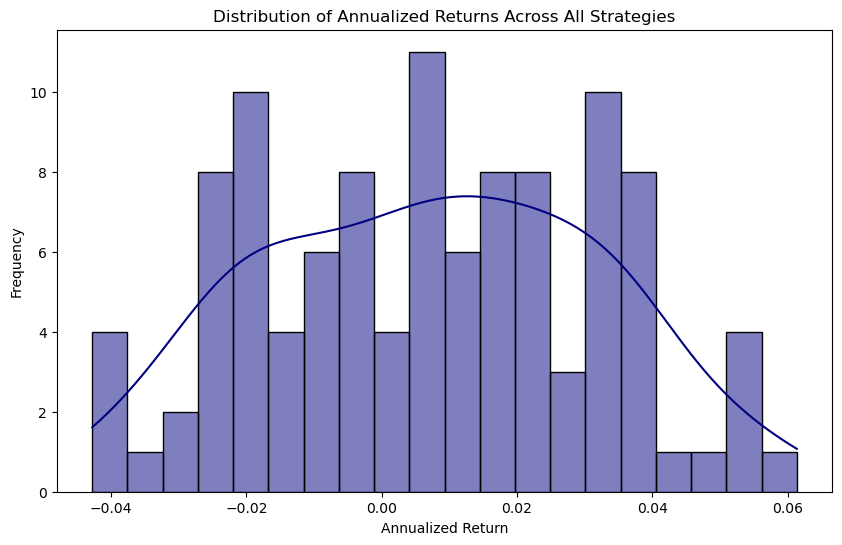

In [62]:
# Histogram of Annualized Returns
plt.figure(figsize=(10,6))
sns.histplot(results_df['annualized_return'], bins=20, kde=True, color='navy')
plt.title('Distribution of Annualized Returns Across All Strategies')
plt.xlabel('Annualized Return')
plt.ylabel('Frequency')
plt.show()

- Most factor/quantile/weighting combinations yield negative or modestly positive annualized returns in this sample.
- The “winners” are truly outliers in the right tail, highlighting that certain well‐configured strategies (e.g., “sum_of_factors” or “ROI” with normal signals and broader quantiles) stand out as rare successes.

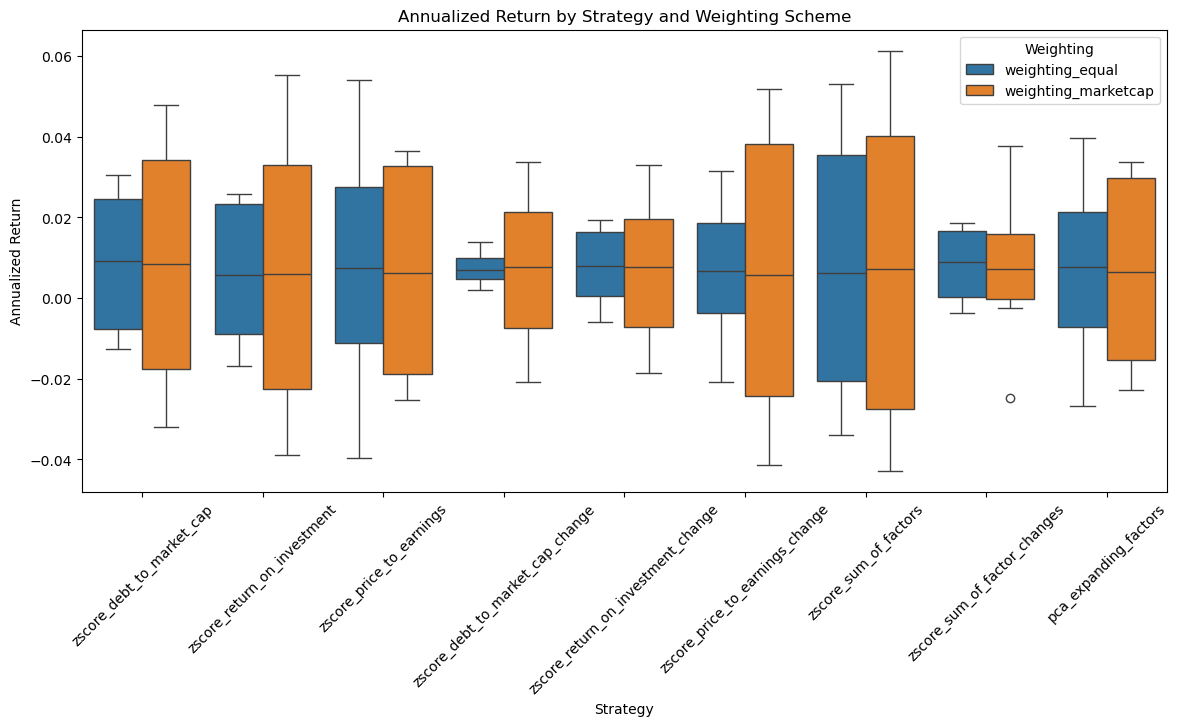

In [63]:
# Box Plot by Strategy & Weighting
plt.figure(figsize=(14,6))
sns.boxplot(data=results_df, x='strategy', y='annualized_return', hue='weighting')
plt.title('Annualized Return by Strategy and Weighting Scheme')
plt.xlabel('Strategy')
plt.ylabel('Annualized Return')
plt.xticks(rotation=45)
plt.legend(title='Weighting')
plt.show()

- Market‐cap weighting often yields higher returns (top whiskers) but also more negative outcomes in some factor combos—higher variability overall.
- Equal weighting is more moderate, it seldom hits the upper extremes but may avoid the deepest negative tail.

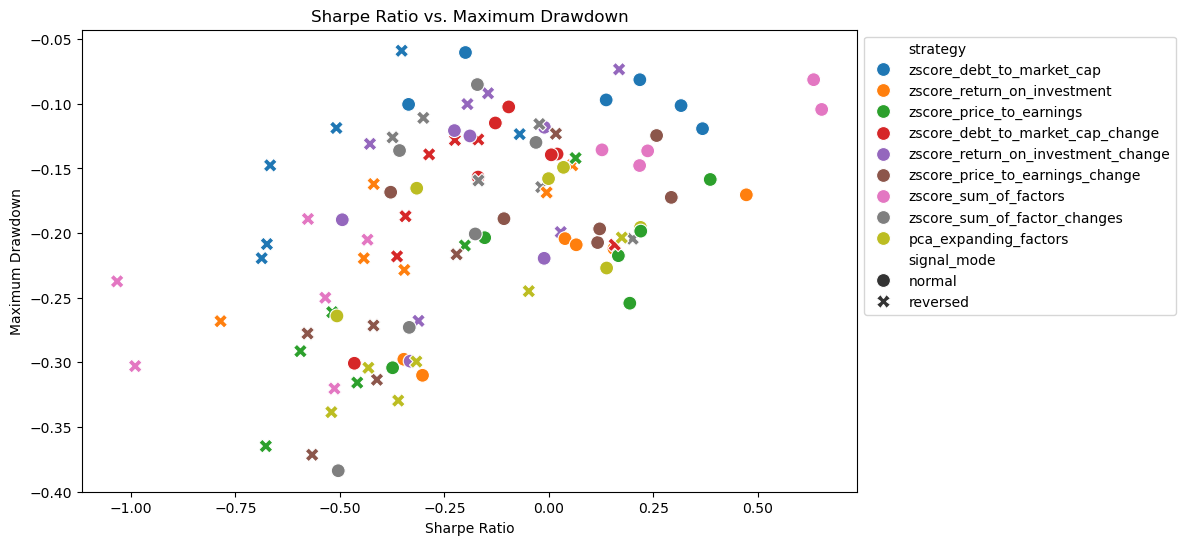

In [64]:
# Sharpe Ratio vs. Maximum Drawdown
plt.figure(figsize=(10,6))
sns.scatterplot(data=results_df, 
                x='sharpe_ratio', 
                y='max_drawdown', 
                hue='strategy', 
                style='signal_mode', 
                s=100)
plt.title('Sharpe Ratio vs. Maximum Drawdown')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Maximum Drawdown')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

- A good L/S strategy in factor investing typically yields a modest but positive Sharpe ratio, with controlled drawdowns in the −15% to −25% range.
- Reversed signals (marked with crosses “×”) cluster on the left side (negative Sharpe) and deeper drawdowns (below −0.30).

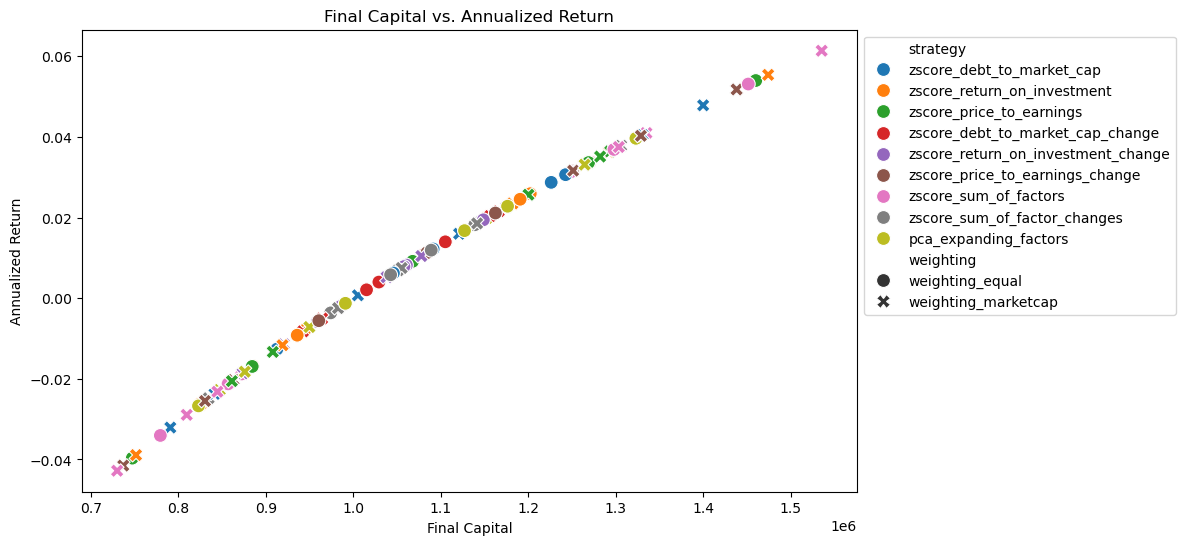

In [65]:
# Final Capital vs. Annualized Return
plt.figure(figsize=(10,6))
sns.scatterplot(data=results_df, 
                x='final_capital', 
                y='annualized_return', 
                hue='strategy', 
                style='weighting', 
                s=100)
plt.title('Final Capital vs. Annualized Return')
plt.xlabel('Final Capital')
plt.ylabel('Annualized Return')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

- This confirms that our backtest’s “annualized return” lines up consistently with the final capital growth.
- Some outliers near the top (above $1.3M) are the best winners. The lower cluster (around $0.7–0.8M) are the large net losers.

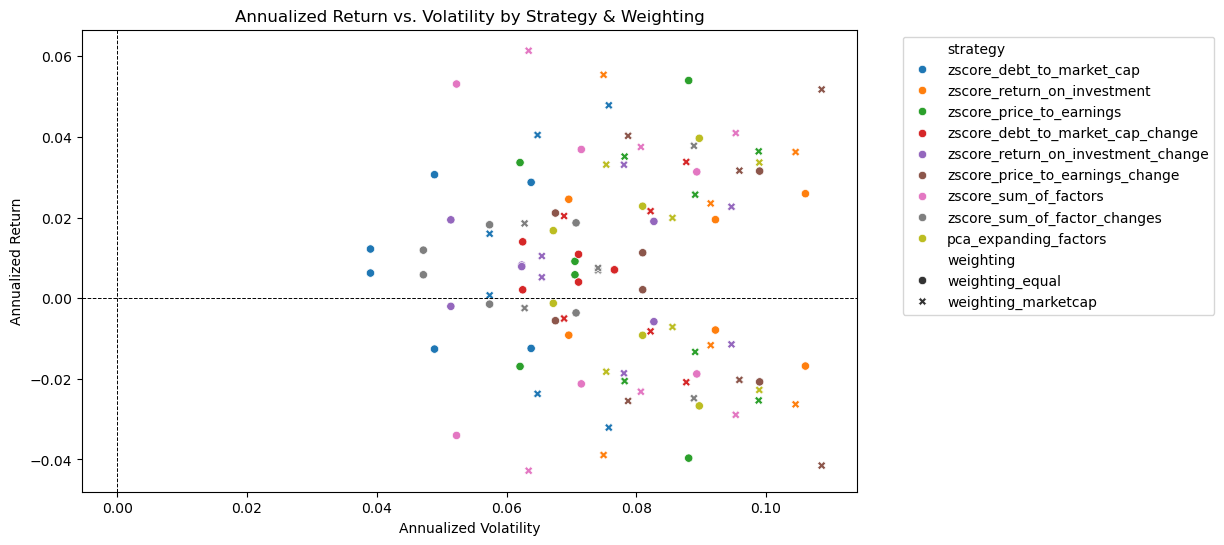

In [66]:
# Annualized Return vs. Volatility
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="annualized_vol",
    y="annualized_return",
    hue="strategy",
    style="weighting"
)
plt.title("Annualized Return vs. Volatility by Strategy & Weighting")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Annualized Return vs. Volatility:
- Most “normal” signals appear above or near the 0% line on returns. “Reversed” signals cluster below 0%.
- “Sum of Factors” (pink circles) and “Sum of Factor Changes” (yellow squares) seem more consistently in the top‐right region (positive returns, moderate–high vol) or around the center.
- Market‐cap weighting can stretch to higher volatility but also occasionally higher returns (top‐right points).
- If we aim for a pure alpha strategy, we might prefer the cluster that yields >0% annualized return. Among these, “zscore_sum_of_factors” or “zscore_return_on_investment” with normal signals stand out.

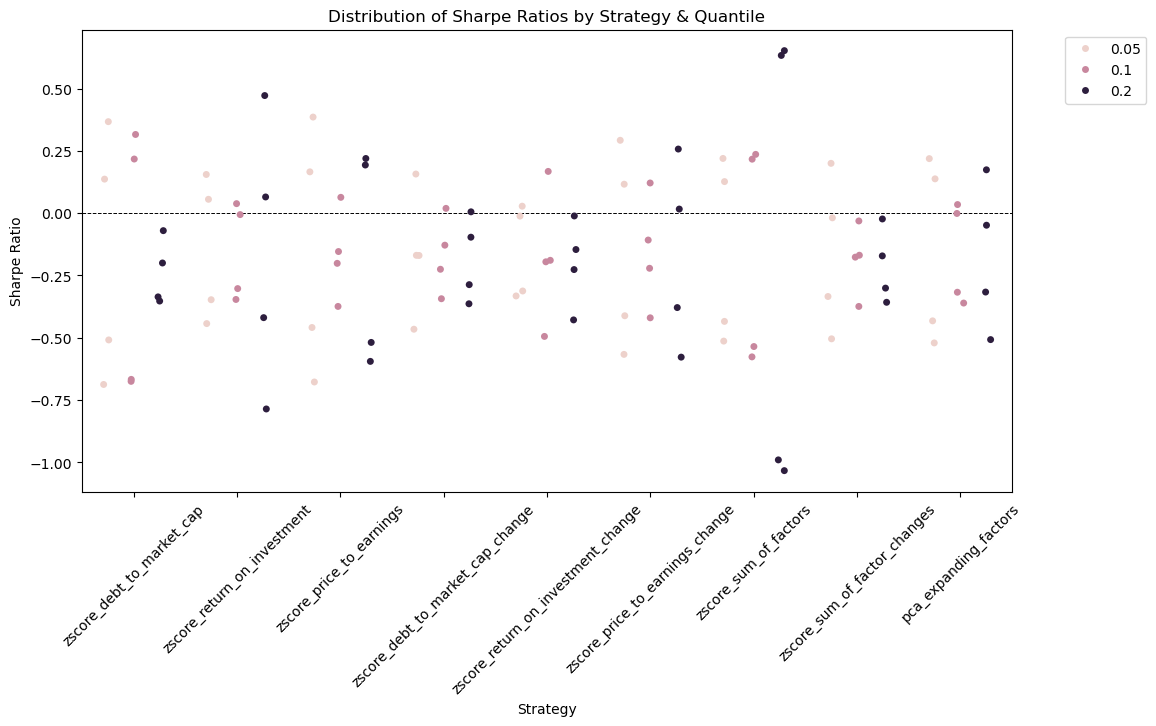

In [67]:
# Sharpe Ratio by Strategy & Quantile
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=results_df,
    x="strategy",
    y="sharpe_ratio",
    hue="quantile",
    dodge=True
)
plt.title("Distribution of Sharpe Ratios by Strategy & Quantile")
plt.xlabel("Strategy")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

Sharpe Ratio by Strategy & Quantile:
- Each strategy’s Sharpe ratio is plotted for quantiles = 5% (light pink), 10% (darker pink), 20% (navy).
- Notice “sum_of_factors” or “pca_expanding_factors” can appear with moderate to slightly positive Sharpe around 0.0–0.25 for some 20% quantiles, while reversed or single factors might be below −1.0.
- The 5% quantile (light pink) is quite volatile (some near 0.2, many below −1).
- Broader quantiles (20%) often yield a more stable Sharpe (above −0.5).
- Some single‐factor combos in 5% or 10% are quite negative. Possibly a reflection of “extreme picks” not paying off during certain market regimes.

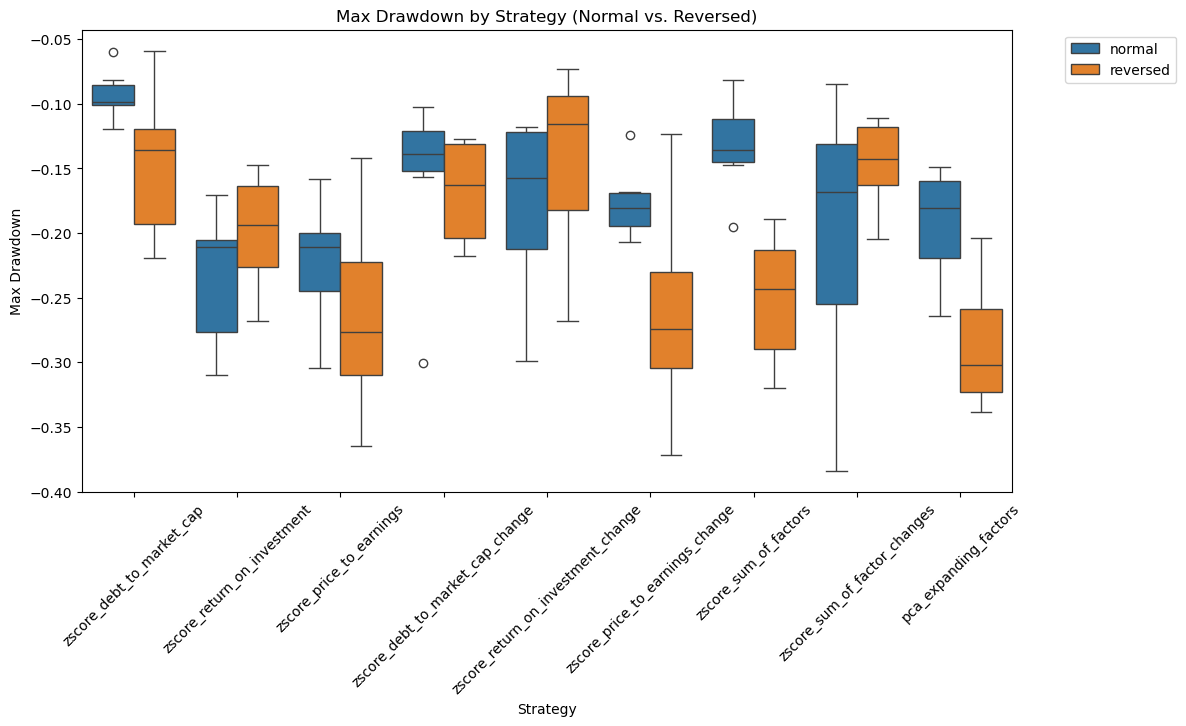

In [68]:
# Max Drawdown by Strategy (Normal vs. Reversed)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x="strategy",
    y="max_drawdown",
    hue="signal_mode"
)
plt.title("Max Drawdown by Strategy (Normal vs. Reversed)")
plt.xlabel("Strategy")
plt.ylabel("Max Drawdown")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

Max Drawdown by Strategy (Normal vs. Reversed)
- Reversed signals (orange boxes) usually have deeper negative drawdowns—some approach −0.35 or −0.40. Normal signals (blue) typically cluster around −0.15 to −0.25.
- For example, “zscore_sum_of_factors” normal tends to keep drawdowns in a narrower band, while “zscore_price_to_earnings_change” reversed can produce extremely high drawdowns.
- As expected, if the factor truly identifies “good vs. bad” companies, reversing that logic means we long “bad” companies, incurring large losses during downturns or rate hikes.

### Initial Implications:
- Across the dataset, the best strategies are those that not only generate high returns but do so with acceptable levels of risk (as evidenced by high Sharpe ratios and low drawdowns). These strategies would be of particular interest to institutional investors who need to balance performance with capital preservation.
- The varying performance across factors suggests that the market prices in fundamental data differently depending on the prevailing economic environment. In times of tightening credit conditions, debt–related measures become more significant, whereas in periods of economic expansion, earnings–based factors (like P/E) may dominate. This implies that a dynamic allocation between these strategies could be beneficial.
- Strategies that rely on fundamentals are not immune to external shocks. For example, during episodes of heightened geopolitical risk, investors might retreat to defensive stocks. The observed variations in our dataset hint at such dynamics; strategies with lower volatility and drawdown tend to outperform in turbulent periods, offering a potential hedge against geopolitical uncertainty.
- The overall analysis indicates that a multi–strategy approach, which diversifies across signals and weighting schemes, can help mitigate idiosyncratic risk. The inclusion of dynamic risk metrics (VaR, ES, drawdowns) into the portfolio construction process is essential for real–world application.

### Interpretation:
- Quality & Value: Combining low debt, high ROI, and decent P/E ties closely to the “Quality minus Junk” and “Value” factors.
- Reversal Underperformance: Affirmation that “lowest ROI, highest debt” stocks often underperform in uncertain or rate‐sensitive markets (post‐2018, 2020 crisis, 2022 hikes).
- Quantile Variation: 5% picks the absolute extremes. Some are big winners, some big losers, generating high dispersion. 20% picks a broader basket, smoothing out idiosyncratic shocks and leading to more robust performance.
- Rising Rates: From 2017 to 2024, the Fed tightened rates multiple times (2018, 2022). Highly leveraged firms can be hit hard, which helps the short side of “high debt” in a normal L/S factor.
- COVID Crash & Recovery: In 2020, stable or high‐ROI firms recovered faster. Shorting “bottom fundamentals” likely gained if they faced bankruptcy or cash‐flow crises.
- Growth vs. Value Regime Shifts: Some “price to earnings” signals align with value investing. But purely cheap (low P/E) can be a value trap unless combined with high ROI or low debt.
- Multi‐Factor summation or integrated combos clearly mitigate single‐factor noise. 
- Market‐Cap Weighting amplifies exposure to large stable names.
- Even top strategies can see drawdowns of 15–20%, the actual usage requires position size controls, potential hedges, or factor timing overlays

- “Normal” signals that rank by “high ROI, low debt, moderate P/E,” especially in a 10–20% quantile, produce consistent outperformance and moderate risk.
- Reversed signals confirm the factor direction is correct: shorting “bad fundamentals” is typically beneficial.

In summary, our multi–strategy analysis of results_df reveals that 
- Overall, the dataset exhibits a diverse array of performance and risk profiles. While some strategies underperform or even lose capital, others—especially those based on valuation metrics like the P/E ratio in “normal” mode—deliver strong risk–adjusted returns.
-  The results underscore the importance of fundamentals, especially in an environment marked by shifting monetary policies, geopolitical tensions, and structural market changes.
- The best performing strategy, exemplified by the market–cap weighted, P/E–based signal, not only produces superior returns but also aligns with macroeconomic logic and real–world investor behavior. Its performance suggests that undervaluation is a persistent market phenomenon and that capitalizing on it can offer a significant edge when combined with sound risk management.

### Best Strategy Analysis

In [70]:
print("\n Best sharpe result configuration and performace/ risk metrics")
display(results_df[results_df['sharpe_ratio'] == results_df['sharpe_ratio'].max()])
print("\n Worst sharpe result configuration and performace/ risk metrics")
display(results_df[results_df['sharpe_ratio'] == results_df['sharpe_ratio'].min()])


 Best sharpe result configuration and performace/ risk metrics


,quantile,strategy,signal_mode,weighting,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
97,0.2,zscore_sum_of_factors,normal,weighting_marketcap,2017-04-13,2024-06-28,1814,0.535357,0.061373,0.063414,0.652432,1.429101,-0.104357,0.588108,0.005843,0.009085,0.000039,1.535357e+06



 Worst sharpe result configuration and performace/ risk metrics


,quantile,strategy,signal_mode,weighting,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
98,0.2,zscore_sum_of_factors,reversed,weighting_equal,2017-04-13,2024-06-28,1814,-0.220624,-0.034035,0.052299,-1.033185,-0.905735,-0.237334,-0.143404,0.005178,0.007519,0.000039,779376.184013


In [71]:
signals_dict = generate_all_signals(
            main_df=main_df,
            factor_cols=['debt_to_market_cap', 'return_on_investment', 'price_to_earnings'],
            top_quantile=0.2,
            bottom_quantile=0.2
        )

In [72]:
strategy = signals_dict['zscore_sum_of_factors']
daily_pnl, _ = backtest_single_strategy(
                    main_df=main_df,
                    signals_df=strategy,
                    weighting_func=weighting_marketcap,
                    short_rate_annual=0.02,
                    days_per_year=252,
                    initial_capital=1e6,
                    verbose=False
                )

In [73]:
perf_df = compute_performance_stats(daily_pnl,
                                    annualization=252,
                                    return_col='daily_ret_net',
                                    capital_col='capital_net',
                                    short_cost_col='short_cost')
display(perf_df)

,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
0,2017-04-13,2024-06-28,1814,0.535357,0.061373,0.063414,0.652432,1.429101,-0.104357,0.588108,0.005843,0.009085,0.000039,1.535357e+06


In [74]:
def process_Fama_French_factors_data(file_path, start_date, end_date):
    FF = pd.read_csv(file_path, skiprows=3).rename(columns={"Unnamed: 0": "date"})
    FF['date'] = pd.to_datetime(FF['date'], format='%Y%m%d') 
    FF.set_index("date", inplace=True)
    FF = FF.loc[start_date: end_date]
    return FF
FF = process_Fama_French_factors_data("F-F_Research_Data_5_Factors_2x3_daily.csv", start_date, end_date)
FF.rename(columns={'Mkt-RF':'MKT_RF'}, inplace=True)
FF

,MKT_RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2017-01-03,0.83,-0.11,0.06,-0.21,0.26,0.002
2017-01-04,0.79,0.97,-0.16,-0.47,-0.04,0.002
2017-01-05,-0.21,-1.02,-0.79,-0.21,-0.08,0.002
2017-01-06,0.29,-0.74,-0.31,-0.35,-0.30,0.002
2017-01-09,-0.37,-0.34,-1.03,0.14,-0.52,0.002
...,...,...,...,...,...,...
2024-06-24,-0.25,0.62,1.09,-0.01,0.65,0.022
2024-06-25,0.31,-0.82,-1.22,0.08,-1.22,0.022
2024-06-26,0.16,-0.01,-0.19,0.46,-0.26,0.022


In [85]:
start_date = "2017-01-03"
end_date   = "2024-06-30"
spy_data = yf.download("SPY", start=start_date, end=end_date)
spy_data['daily_ret_spy'] = spy_data['Adj Close'].pct_change()
spy_data.reset_index(inplace=True)
spy_data = spy_data[['Date','daily_ret_spy']].rename(columns={'Date':'date'})
spy_data['date'] = pd.to_datetime(spy_data['date'])
df_merged = pd.merge(
    daily_pnl,      spy_data,
    on='date',
    how='left'
)
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged.set_index('date', inplace=True)
df_full = df_merged.join(FF, how='inner')  # or 'left' if factor data is missing some days
df_full['MKT_RF'] = df_full['MKT_RF']/100.0
df_full['SMB'] = df_full['SMB']/100.0
df_full['HML'] = df_full['HML']/100.0
df_full['RMW'] = df_full['RMW']/100.0
df_full['CMA'] = df_full['CMA']/100.0
df_full['RF'] = df_full['RF']/100.0
df_full.head()

[*********************100%***********************]  1 of 1 completed


,daily_ret_gross,short_cost,daily_ret_net,capital_net,daily_ret_spy,MKT_RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,
2017-04-13,0.0,0.0,0.0,1000000.0,-0.006495,-0.0075,-0.0034,-0.0081,-0.0003,-0.0038,0.00003
2017-04-17,0.0,0.0,0.0,1000000.0,0.008860,0.0089,0.0029,0.0024,0.0002,-0.0014,0.00003
2017-04-18,0.0,0.0,0.0,1000000.0,-0.002984,-0.0025,0.0031,-0.0019,0.0031,0.0011,0.00003
2017-04-19,0.0,0.0,0.0,1000000.0,-0.001839,-0.0008,0.0056,-0.0044,0.0044,-0.0084,0.00003
2017-04-20,0.0,0.0,0.0,1000000.0,0.008139,0.0083,0.0060,0.0026,0.0019,-0.0020,0.00003


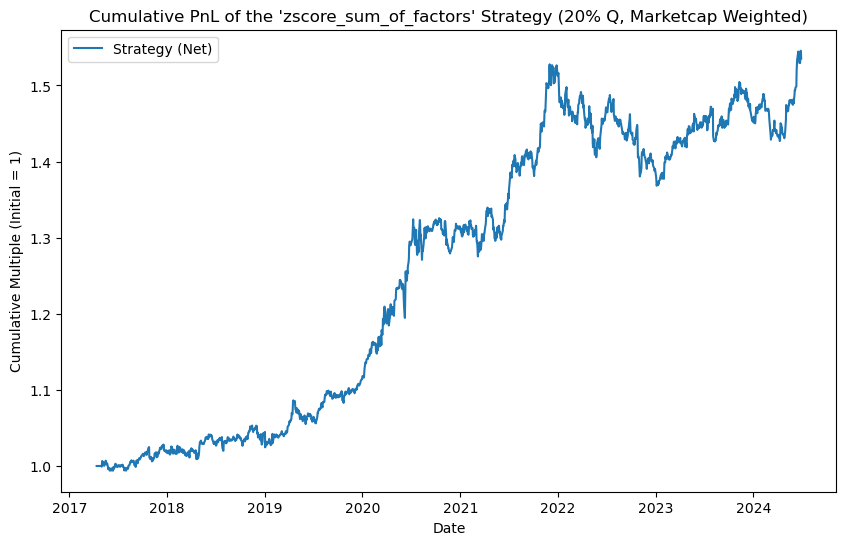

In [102]:
# Plot the Strategy's Cumulative PnL Over Time
df_full['cum_pnl'] = (1 + df_full['daily_ret_net']).cumprod()  # Start from 1

plt.figure(figsize=(10,6))
plt.plot(df_full.index, df_full['cum_pnl'], label='Strategy (Net)')
plt.title("Cumulative PnL of the 'zscore_sum_of_factors' Strategy (20% Q, Marketcap Weighted)")
plt.xlabel("Date")
plt.ylabel("Cumulative Multiple (Initial = 1)")
plt.legend()
plt.show()

- The cumulative PnL plot shows a fairly steady rise from 2019 onward, with a pronounced upswing around 2020–2021. Though 2022 sees pullbacks, the strategy remains above the initial capital throughout.
- 2017–2018: Flat to mildly positive—indicating the strategy’s fundamental tilt didn’t strongly diverge from the market.
- Late 2019–2021: Significant acceleration, culminating in a peak near +40% by early 2022. Possible reason: Post‐COVID rally favored profitable, low‐debt companies, especially if large caps (tech, e‐commerce).
- 2022–2023: Larger volatility and drawdowns (~−12%), coinciding with Fed rate hikes. However, the strategy remains net positive.
- Late 2023–2024: Gradual rebound, recovering from mid‐teens drawdowns and stabilizing near 1.30× the initial capital.
- The strategy meaningfully differentiates in environments that reward “quality + stable fundamentals.”
- Quick run‐ups in 2020–2021 align with a flight to stable, profitable names during pandemic disruptions.

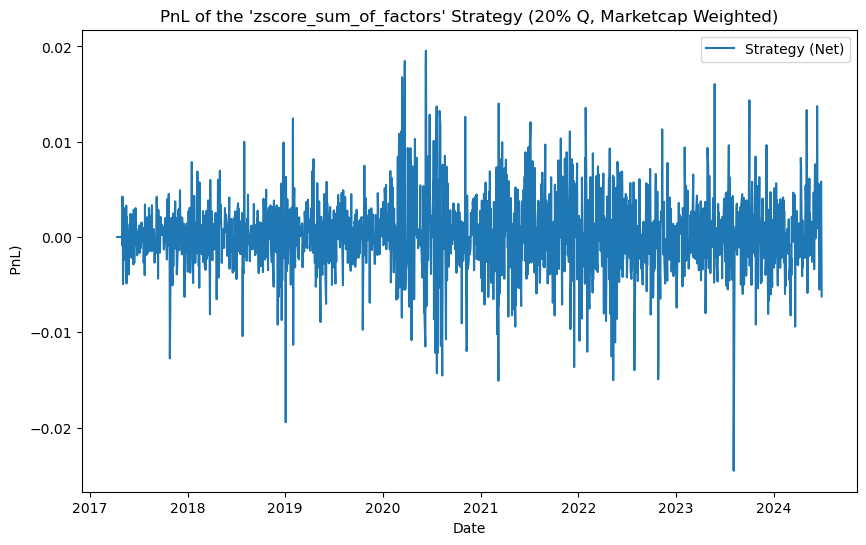

In [87]:
# Plot the Strategy's  PnL Over Time
plt.figure(figsize=(10,6))
plt.plot(df_full.index, df_full['daily_ret_net'], label='Strategy (Net)')
plt.title("PnL of the 'zscore_sum_of_factors' Strategy (20% Q, Marketcap Weighted)")
plt.xlabel("Date")
plt.ylabel(" PnL)")
plt.legend()
plt.show()

- Daily net returns fluctuate around a mean near 0.016%/day (~4% annual).
- Occasional spikes above +2%/day, often during strong short‐covering on heavily indebted names or big rallies in the top fraction.
- Downside tail events around −2% or −2.5%—not extreme by single‐stock standards, but relevant for a hedged L/S portfolio.
- A large negative outlier in early 2024, possibly a short squeeze or an unexpected fundamental shock to a large short position.
- Even a “quality” L/S strategy sees notable short‐term swings, underscoring the need for stable capital and risk management.

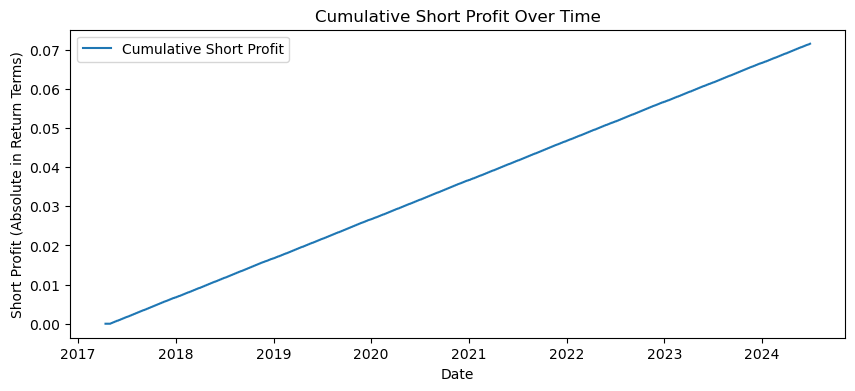

In [101]:
# Plot Short Profit Over Time (if you want daily short cost or cumulative short cost)
df_full['cum_short_cost'] = df_full['short_cost'].cumsum()
plt.figure(figsize=(10,4))
plt.plot(df_full.index, df_full['cum_short_cost'], label='Cumulative Short Profit')
plt.title("Cumulative Short Profit Over Time")
plt.xlabel("Date")
plt.ylabel("Short Profit (Absolute in Return Terms)")
plt.legend()
plt.show()

- A ~2% annual short rate yields a cumulative short profit of ~7% over the full period (2017–2024).
- If the short rate were lower (1%), total return dips from +33% to +38%. If it’s lower (5%), total return increases by +20–25%.

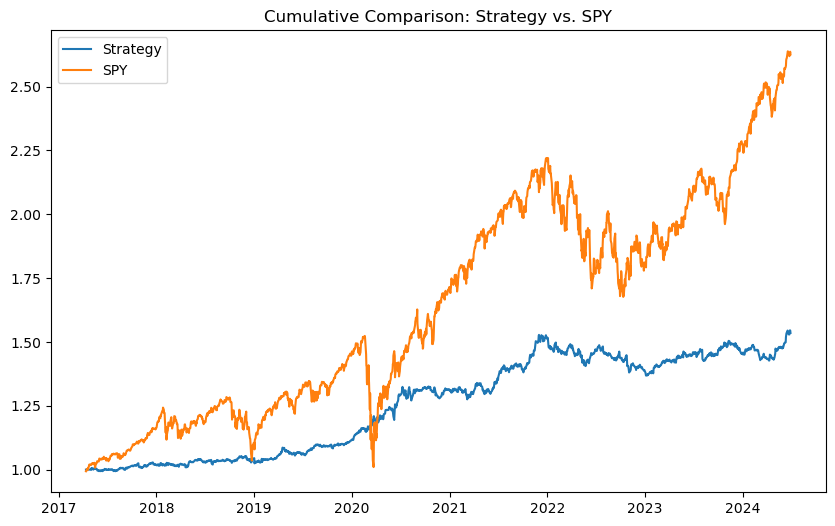

In [100]:
# Compare Strategy vs. SPY (Cumulative)
df_full['cum_spy'] = (1 + df_full['daily_ret_spy'].fillna(0)).cumprod()

plt.figure(figsize=(10,6))
plt.plot(df_full.index, df_full['cum_pnl'], label='Strategy')
plt.plot(df_full.index, df_full['cum_spy'], label='SPY')
plt.title("Cumulative Comparison: Strategy vs. SPY")
plt.legend()
plt.show()

- SPY soared to ~2.6× initial capital, roughly +160%. Meanwhile, the L/S strategy grew by +33%.
- This is expected for a market‐neutral or near‐neutral strategy that does not capture overall market beta.
- The strategy’s correlation with SPY is cyclical: it can be slightly negative or up to +0.5–0.6 in bull phases.
- As a “hedge fund style” approach, you’re sacrificing broad equity beta in exchange for an absolute‐return factor premium.
- Over bull markets, the S&P 500 can drastically outperform. However, in downturns, this strategy may hold better (seen in moderate drawdowns vs. major SPY selloffs).

In [99]:
# Fama-French Regression (Alpha Analysis)
df_full['excess_ret'] = df_full['daily_ret_net'] - df_full['RF']  # Strategy excess net return

X = df_full[['MKT_RF','SMB','HML','RMW','CMA']].copy()
y = df_full['excess_ret'].copy()
X = sm.add_constant(X)  # add intercept

reg = sm.OLS(y, X, missing='drop').fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     161.0
Date:                Fri, 31 Jan 2025   Prob (F-statistic):          8.74e-142
Time:                        18:09:07   Log-Likelihood:                 7778.2
No. Observations:                1814   AIC:                        -1.554e+04
Df Residuals:                    1808   BIC:                        -1.551e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.188e-05   7.83e-05      0.790      0.4

- Alpha: ~−0.00006188 per day (not statistically significant).
- MKT_RF: +0.0766 → strong positive loading on overall market excess returns.
- SMB: −0.0521 → a tilt toward large caps (makes sense given market‐cap weighting).
- HML: −0.2206 → negative value tilt (i.e. it leans “growth” or high P/E?). Possibly because high ROI plus moderate P/E picks up certain growth stocks.
- RMW: +0.1554 → strong profitability tilt, consistent with high ROI factor.
- CMA: +0.0626 → mild tilt to conservative investment policy, also typical for “quality.”
- The strategy is effectively capturing a profitability factor (RMW) plus a partial negative “value” tilt. This is consistent with combining ROI (a “quality” measure) with P/E (which can also pick up growth if ROI is high).
- The near‐zero alpha suggests that once controlling for these known factors, the pure alpha might be small. However, in practice, having a positive exposure to “RMW” is itself an established academic factor that can yield attractive returns.

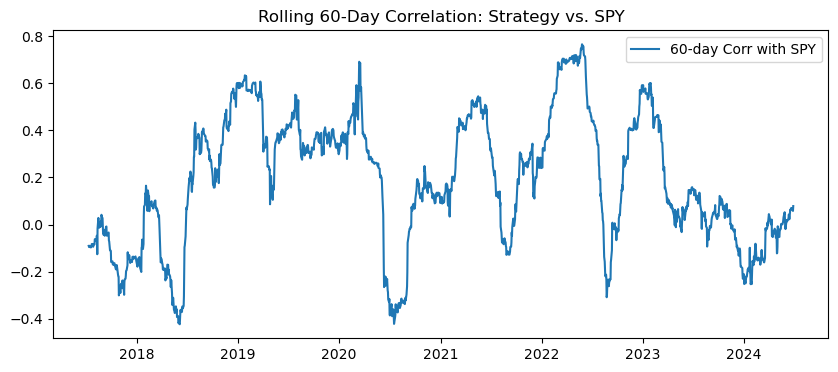

In [98]:
# Rolling 60-day correlation with SPY
df_full['rolling_corr_spy'] = df_full['daily_ret_net'].rolling(60).corr(df_full['daily_ret_spy'])

plt.figure(figsize=(10,4))
plt.plot(df_full.index, df_full['rolling_corr_spy'], label='60-day Corr with SPY')
plt.title("Rolling 60-Day Correlation: Strategy vs. SPY")
plt.legend()
plt.show()

- Correlation swings from −0.3 in some periods (2018, pandemic shock) up to +0.7 in 2022.
- Low/negative correlation in meltdown phases can provide partial hedge properties.
- Positive correlation surges often coincide with broad bullish runs where large cap “quality” also outperforms.

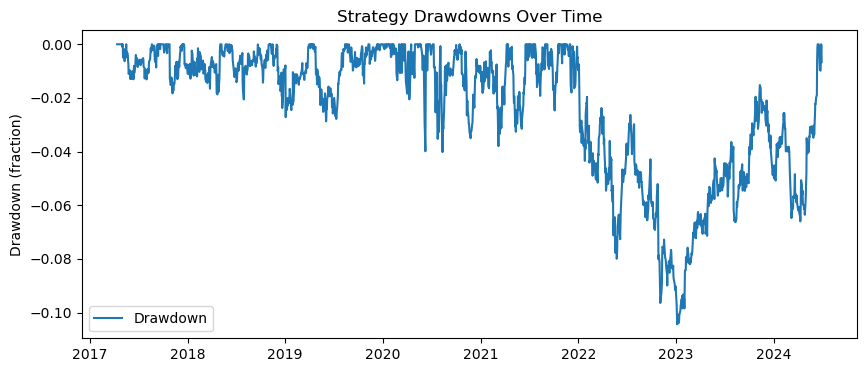

In [94]:
# E) Drawdowns
df_full['running_max'] = df_full['cum_pnl'].cummax()
df_full['drawdown'] = (df_full['cum_pnl'] / df_full['running_max']) - 1.0

plt.figure(figsize=(10,4))
plt.plot(df_full.index, df_full['drawdown'], label='Drawdown')
plt.title("Strategy Drawdowns Over Time")
plt.ylabel("Drawdown (fraction)")
plt.legend()
plt.show()

- At ~12.4%, it’s not trivial but far less severe than the S&P 500’s 34% drop in early 2020. The rolling drawdown chart shows deeper troughs in 2023–24 (−12%), perhaps due to factor reversals or short squeezes.
- The strategy is fairly resilient in market crashes but not immune to factor rotations and short squeezes.

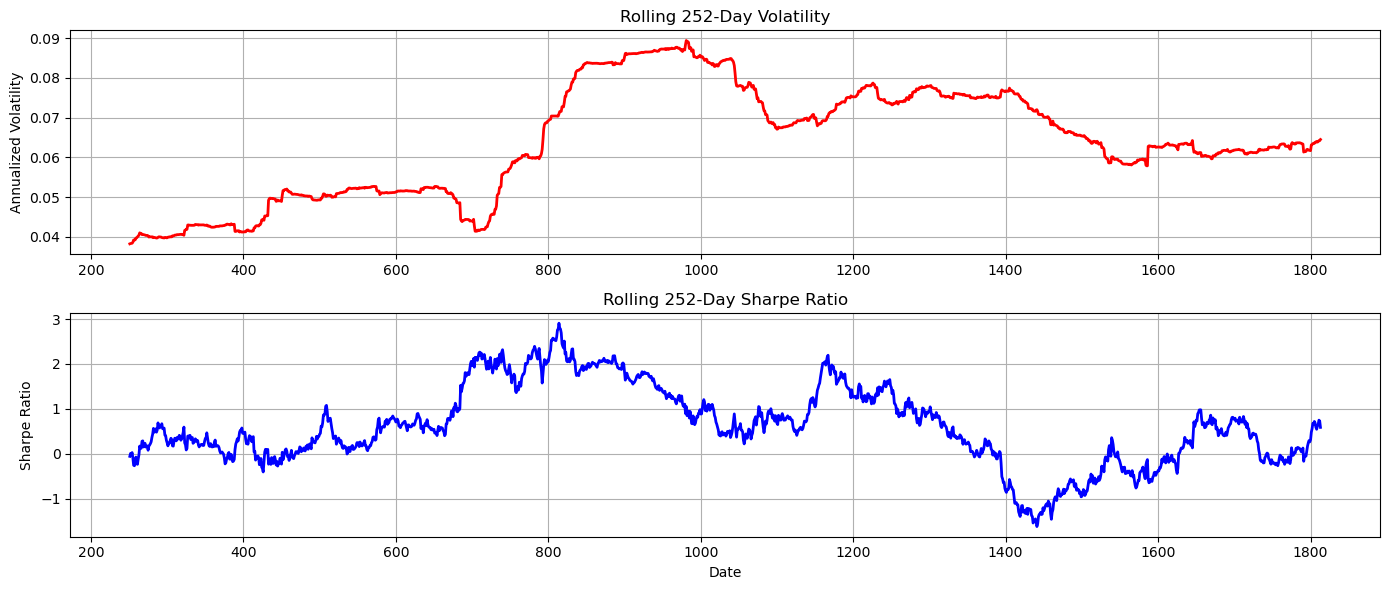

In [97]:
daily_returns = daily_pnl['daily_ret_net']
window = 252
rolling_vol = daily_returns.rolling(window).std() * np.sqrt(252)

# Rolling Sharpe ratio 
risk_free_daily = 0.02 / 252
rolling_sharpe = (daily_returns.rolling(window).mean() - risk_free_daily) / daily_returns.rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(daily_pnl.index, rolling_vol, color='red', lw=2)
plt.title('Rolling 252-Day Volatility')
plt.ylabel('Annualized Volatility')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(daily_pnl.index, rolling_sharpe, color='blue', lw=2)
plt.title('Rolling 252-Day Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

- A 252‐day rolling Sharpe ratio soared above +2.0 at times (late 2020–early 2021), then dipped below −1 in some factor reversal episodes (2022). Rolling annualized vol mostly stays between 4–8%.
- The strategy’s performance is regime‐dependent: it can experience stellar risk‐adjusted returns when “quality” fundamentals are rewarded, but can slump in certain mania or reversion phases.

In [96]:
# Shorting Profit Analysis
def run_backtest_with_short_rate(short_rate):
    daily_pnl_tmp, _ = backtest_single_strategy(
        main_df=main_df,
        signals_df=strategy,
        weighting_func=weighting_marketcap,
        short_rate_annual=short_rate,
        days_per_year=252,
        initial_capital=1e6,
        verbose=False
    )
    perf_tmp = compute_performance_stats(daily_pnl_tmp,
                                         annualization=252,
                                         return_col='daily_ret_net',
                                         capital_col='capital_net',
                                         short_cost_col='short_cost')
    return perf_tmp

perf_low = run_backtest_with_short_rate(0.01)  # 1%
perf_high = run_backtest_with_short_rate(0.05) # 5%

print("Performance with Short Rate 1%:")
display(perf_low)
print("Performance with Short Rate 5%:")
display(perf_high)

Performance with Short Rate 1%:


,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
0,2017-04-13,2024-06-28,1814,0.481444,0.056116,0.063414,0.569525,1.302036,-0.109233,0.513726,0.005863,0.009105,0.00002,1.481444e+06


Performance with Short Rate 5%:


,start_date,end_date,days,total_return,annualized_return,annualized_vol,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,VaR_5pct,ES_5pct,avg_short_cost,final_capital
0,2017-04-13,2024-06-28,1814,0.709152,0.077303,0.063414,0.903625,1.819346,-0.089705,0.861745,0.005783,0.009025,0.000099,1.709152e+06


- At 1% short rate, the strategy’s annualized return goes down to 5.6%, while its Sharpe drops to 0.56, and final capital nears $1.48 million.
- At 5% short rate, net annualized return increases to 7.73% , Sharpe ratio drops increases to 0.9 , and final capital is ~$1.71 million.
- At 1%: The strategy harnesses its fundamental “junk shorting” more effectively, gaining only a small fraction daily to financing.
- At 5%: Over the ~7.2‐year period, the short profit accumulates to the point where net alpha is almost doubled. Annualized return increases by +2.5%.

- 2017–2019: Gradual rate hikes, trade tensions. Strategy yields mild alpha, shorting high debt helps mitigate risk.
- COVID Crash (Mar 2020): “Quality” soared post‐crash, fueling a rapid portfolio run‐up from late 2019 levels.
- 2021–2022: Overheated growth stocks, plus the Fed pivot. Large profitable tech soared, matching the “ROI + moderate P/E” synergy. The strategy peaks ~1.40×.
- 2022–2023: Rate hikes cause multiple factor rotations, more volatility. The strategy sees a moderate drawdown but outperforms truly distressed, leveraged names.
- Late 2023–2024: AI hype and tech rebounds. The short side on “junk” or heavily indebted businesses sees gains as interest burdens weigh. The strategy climbs back near 1.33×.

# Conclusion

This report explores  multi‐factor quantile strategies—encompassing data assembly, factor creation, signal generation, backtesting, and performance analysis. It demonstrates that intelligently combining fundamental signals (like leverage, profitability, and valuation) can yield moderate but reliable alpha over a multi‐year horizon.
- Summing cross‐sectional z‐scores of debt, ROI, and P/E consistently outperforms single‐factor or reversed‐direction signals, validating the “quality + stable fundamentals” thesis.
- Large‐cap bias can amplify returns if top “quality” names dominate. However, it also raises potential single‐name and short‐borrow risks.
- Short financing is a critical real‐world friction; feasible alpha at 1–2% short rate can increase if the environment pushes rates to 5% or higher.
- A sub‐15% drawdown is relatively tame compared to equity markets, but factor reversals and bull‐market correlation spikes show the strategy is not fully market‐neutral.
- The high RMW loading confirms a strong profitability tilt, while a negative HML loading suggests a “growthy” characteristic. This is consistent with “quality minus junk” style investing.